Plot lipid 3D tracks at dyn1 sites in various ways, in 2D cross sections or 3D plots.

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.cm import ScalarMappable
import tifffile as tiff
import sys
sys.path.append("..")
import obf_support

plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'arial'

def consecutive_bool(data, stepsize=1):
    return np.split(data, np.where(np.diff(data) != stepsize)[0]+1)

def reject_outliers(data, m=3.):
    # from: https://stackoverflow.com/a/16562028
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else np.zeros(len(d))
    return data[s<m]

# set manual parameters
window_pts = 70
len_lim = 10
dt_loc_thresh = 550
stdfact = 1.7
xdepth = 0.05
ydepth = 0.05
zstep = 0.04

parentdir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [2]:
folder = os.path.join(parentdir, 'exampledata\\dyn1\\241101\\sample1\\cell2\\e1')

c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102442_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102510_conf-raw.tif
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102855_minflux.msr


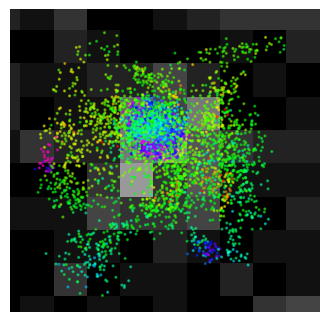

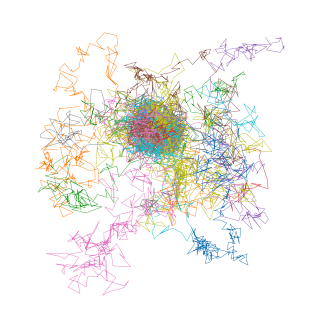

In [3]:
### Filter and plot all tracks in 2D XY
%matplotlib inline
plt.style.use('default')

tp = 0  # timepoint/cycle to plot

filelist_all = os.listdir(folder)
filelist_npy = [file for file in filelist_all if file.endswith('.npy')]
filelist_conf = [file for file in filelist_all if file.endswith('.tif') if 'conf-raw' in file]
filelist_msr = [file for file in filelist_all if file.endswith('.msr')]

file_npy = os.path.join(folder, filelist_npy[tp])
dataset = np.load(file_npy)
print(file_npy)
file_conf = os.path.join(folder, filelist_conf[tp])
print(file_conf)
file_msr = os.path.join(folder, filelist_msr[0])
print(file_msr)

# load msr file to read confocal image settings
# get metadata from confocal image in msr file (pixel size, image shape, image size, origin offset)
file_msr = os.path.join(folder, filelist_msr[0])
msr_dataset = obf_support.File(file_msr)
conf_msr_stack_index = 0  # in currently used imspector template file, the confocal dataset is always stack 0 in the .msr file. This might change with other templates used.
conf_stack = msr_dataset.stacks[conf_msr_stack_index]
pxsize = conf_stack.pixel_sizes[0]*1e6
pxshift = pxsize/2
conf_size_px = (conf_stack.shape[0], conf_stack.shape[1])
conf_size = (conf_stack.lengths[0]*1e6, conf_stack.lengths[1]*1e6)
conf_offset = (conf_stack.offsets[0]*1e6, conf_stack.offsets[1]*1e6)

# load confocal image and imshow it
file_rawtif = os.path.join(folder, filelist_conf[tp])
conf_stack = tiff.imread(file_rawtif)
conf_img = conf_stack[-1]

fig3 = plt.figure(figsize=(4,4))
ax3 = plt.gca()
conf_img_plot = ax3.imshow(conf_img, cmap='gray', alpha=1, vmax=15)
extents_confimg = np.array(conf_img_plot.get_extent())*pxsize+[pxsize/2, pxsize/2, pxsize/2, pxsize/2]+[conf_offset[0], conf_offset[0], conf_offset[1], conf_offset[1]]
conf_img_plot.set_extent(extents_confimg)  # scale overlay image to the correct pixel size for the tracks

roi_name = int(file_npy.split('ROI')[1].split('-')[0])
roi_pos = (int(file_npy.split('[')[1].split(',')[0]),int(file_npy.split(']')[0].split(',')[1]))
roi_pos_um = (roi_pos[0]*pxsize+conf_offset[0], roi_pos[1]*pxsize+conf_offset[1])

# get all (x,y,z) coodinates and plot them in a 3D scatter
loc_it = 4

x = np.zeros((len(dataset),1))
y = np.zeros((len(dataset),1))
z = np.zeros((len(dataset),1))
z1 = np.zeros((len(dataset),1))
tid = np.zeros((len(dataset),1))
tim = np.zeros((len(dataset),1))
efo = np.zeros((len(dataset),1))
for i in range(len(dataset)):
    x[i] = dataset[i][0][loc_it][2][0]
    y[i] = dataset[i][0][loc_it][2][1]
    z[i] = dataset[i][0][loc_it][2][2]
    z1[i] = dataset[i][0][1][2][2]
    efo[i] = dataset[i][0][loc_it][6]
    tid[i] = dataset[i][4]
    tim[i] = dataset[i][3]
x = x * 1e6
x = x.flatten()
xlim = [np.min(x), np.max(x)]
y = y * 1e6
y = y.flatten()
ylim = [np.min(y), np.max(y)]
z = z * 1e6
z = z * 0.7  # z scaling for immersion mismatch
z = z.flatten()
zlim = [np.min(z)+0.2, np.max(z)-0.2]
z1 = z1 * 1e6
z1 = z1.flatten()
tid = tid.flatten()
tim = tim.flatten()
efo = efo.flatten()
track_ids = list(map(int, set(tid)))
track_ids.sort()
data_df = pd.DataFrame(columns=['tridx', 'tim0', 'x', 'y', 'z', 'tim', 'dt', 'efo', 'lims', 'z1', 'z1_diff', 'z_std', 'z_range'])
for track in track_ids[::]:
    data_row = []
    x_track = np.array([val for val,tr in zip(x,tid) if tr==track]).flatten()
    y_track = np.array([val for val,tr in zip(y,tid) if tr==track]).flatten()
    z_track = np.array([val for val,tr in zip(z,tid) if tr==track]).flatten()
    z1_track = np.array([val for val,tr in zip(z1,tid) if tr==track]).flatten()
    tim_track = np.array([val for val,tr in zip(tim,tid) if tr==track]).flatten()
    efo_track = np.array([val for val,tr in zip(efo,tid) if tr==track]).flatten()
    z_diff = z_track - z1_track[0]
    data_row.append(track)
    data_row.append(tim_track[0])
    data_row.append(x_track)
    data_row.append(y_track)
    data_row.append(z_track)
    tim_track = tim_track - tim_track[0]
    data_row.append(tim_track)
    data_row.append(np.diff(tim_track))
    data_row.append(efo_track)
    data_row.append([np.min(x), np.max(x), np.min(y), np.max(y), np.min(z), np.max(z)])
    data_row.append(z1_track)
    data_row.append(z_diff)
    data_row.append(np.std(z_track))
    data_row.append(np.max(z_track)-np.min(z_track))
    data_df = pd.concat([data_df, pd.DataFrame([data_row], columns=data_df.columns)], ignore_index=True)

zstds = []
zspans = []
max_efo = 0
max_tim = 0
max_dt = 0

fig1 = plt.figure(figsize=(4,4))
ax1 = plt.gca()
trs = np.arange(0,len(data_df))
for tr in trs:
    dt_track_full = np.array(data_df.iloc[tr]['dt'])*1e6
    dt_track_full = np.insert(dt_track_full,0,0)
    if len(dt_track_full) > window_pts:
        local_dt_full = []
        for i in np.arange(0, len(dt_track_full)):
            if i > int(window_pts/2) and i < len(dt_track_full)-int(window_pts/2)-1:
                local_dt_full.append(np.mean(dt_track_full[i-int(window_pts/2):i+int(window_pts/2)]))
            else:
                local_dt_full.append(np.nan)
        local_dt_full = np.array(local_dt_full)
        idx_lists = consecutive_bool(np.argwhere(local_dt_full<dt_loc_thresh).flatten())
        # loop through all accepted tracks
        for idx_list in idx_lists:
            dt_track = dt_track_full[idx_list]
            if len(dt_track) > len_lim:
                x_track = data_df.iloc[tr]['x'][idx_list]
                y_track = data_df.iloc[tr]['y'][idx_list]
                z_track = data_df.iloc[tr]['z'][idx_list]
                tim_track = data_df.iloc[tr]['tim'][idx_list]
                efo_track = data_df.iloc[tr]['efo'][idx_list]
                local_dt = local_dt_full[idx_list]
                z1_track = data_df.iloc[tr]['z1'][idx_list]
                z1diff_track = data_df.iloc[tr]['z1_diff'][idx_list]
                zstd = np.std(z_track)
                zspan = np.max(z_track)-np.min(z_track)
                zstds.append(zstd)
                zspans.append(zspan)

                if np.max(efo_track) > max_efo:
                    max_efo = np.max(efo_track)
                if np.max(dt_track) > max_dt:
                    max_dt = np.max(dt_track)
                if np.max(tim_track) > max_tim:
                    max_tim = np.max(tim_track)

                local_efo = []
                for i in np.arange(0, len(efo_track)):
                    if i > int(window_pts/2) and i < len(dt_track)-int(window_pts/2)-1:
                        local_efo.append(np.mean(efo_track[i-int(window_pts/2):i+int(window_pts/2)]))
                    else:
                        local_efo.append(np.nan)
                sc = ax1.plot(x_track,y_track, linewidth=0.3)
                sc = ax3.scatter(x_track,y_track,c=z_track,cmap=cm.gist_rainbow,s=1.5,alpha=0.5,vmin=-0.1, vmax=0.1)
ax1.set_xlim(*xlim)
ax1.set_ylim(*ylim)
ax1.set_aspect('equal', adjustable='box')
ax1.set_axis_off()
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax3.set_xlim(*xlim)
ax3.set_ylim(*ylim)
ax3.set_axis_off()

plt.show()

c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102442_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


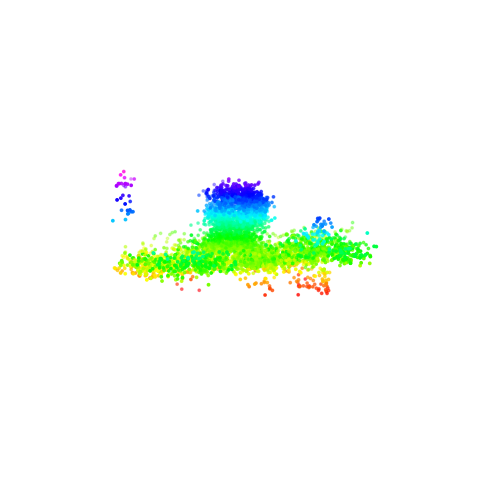

In [4]:
### Filter and plot all tracks in 3D, and plot some statistics on filtered tracks
%matplotlib inline

tp = 0  # timepoint/cycle to plot

filelist = os.listdir(folder)
filelist = [file for file in filelist if file.endswith('.npy')]

file = os.path.join(folder, filelist[tp])
dataset = np.load(file)
print(file)

# get all (x,y,z) coodinates and plot them in a 3D scatter
loc_it = 4

x = np.zeros((len(dataset),1))
y = np.zeros((len(dataset),1))
z = np.zeros((len(dataset),1))
z1 = np.zeros((len(dataset),1))
tid = np.zeros((len(dataset),1))
tim = np.zeros((len(dataset),1))
efo = np.zeros((len(dataset),1))
for i in range(len(dataset)):
    x[i] = dataset[i][0][loc_it][2][0]
    y[i] = dataset[i][0][loc_it][2][1]
    z[i] = dataset[i][0][loc_it][2][2]
    z1[i] = dataset[i][0][1][2][2]
    efo[i] = dataset[i][0][loc_it][6]
    tid[i] = dataset[i][4]
    tim[i] = dataset[i][3]
x = x * 1e6
x = x.flatten()
y = y * 1e6
y = y.flatten()
z = z * 1e6
z = z * 0.7  # z scaling for immersion mismatch
z = z.flatten()
z1 = z1 * 1e6
z1 = z1.flatten()
tid = tid.flatten()
tim = tim.flatten()
efo = efo.flatten()
track_ids = list(map(int, set(tid)))
track_ids.sort()
data_df = pd.DataFrame(columns=['tridx', 'tim0', 'x', 'y', 'z', 'tim', 'dt', 'efo', 'lims', 'z1', 'z1_diff', 'z_std', 'z_range'])
for track in track_ids[::]:
    data_row = []
    x_track = np.array([val for val,tr in zip(x,tid) if tr==track]).flatten()
    y_track = np.array([val for val,tr in zip(y,tid) if tr==track]).flatten()
    z_track = np.array([val for val,tr in zip(z,tid) if tr==track]).flatten()
    z1_track = np.array([val for val,tr in zip(z1,tid) if tr==track]).flatten()
    tim_track = np.array([val for val,tr in zip(tim,tid) if tr==track]).flatten()
    efo_track = np.array([val for val,tr in zip(efo,tid) if tr==track]).flatten()
    z_diff = z_track - z1_track[0]
    data_row.append(track)
    data_row.append(tim_track[0])
    data_row.append(x_track)
    data_row.append(y_track)
    data_row.append(z_track)
    tim_track = tim_track - tim_track[0]
    data_row.append(tim_track)
    data_row.append(np.diff(tim_track))
    data_row.append(efo_track)
    data_row.append([np.min(x), np.max(x), np.min(y), np.max(y), np.min(z), np.max(z)])
    data_row.append(z1_track)
    data_row.append(z_diff)
    data_row.append(np.std(z_track))
    data_row.append(np.max(z_track)-np.min(z_track))
    data_df = pd.concat([data_df, pd.DataFrame([data_row], columns=data_df.columns)], ignore_index=True)

zstds = []
zspans = []
max_efo = 0
max_tim = 0
max_dt = 0

fig1 = plt.figure(figsize=(20,6))
ax1 = fig1.add_subplot(1,1,1,projection='3d')
trs = np.arange(0,len(data_df))
for tr in trs:
    dt_track_full = np.array(data_df.iloc[tr]['dt'])*1e6
    dt_track_full = np.insert(dt_track_full,0,0)
    if len(dt_track_full) > window_pts:
        local_dt_full = []
        for i in np.arange(0, len(dt_track_full)):
            if i > int(window_pts/2) and i < len(dt_track_full)-int(window_pts/2)-1:
                local_dt_full.append(np.mean(dt_track_full[i-int(window_pts/2):i+int(window_pts/2)]))
            else:
                local_dt_full.append(np.nan)
        local_dt_full = np.array(local_dt_full)
        idx_lists = consecutive_bool(np.argwhere(local_dt_full<dt_loc_thresh).flatten())
        # loop through all accepted tracks
        for idx_list in idx_lists:
            dt_track = dt_track_full[idx_list]
            if len(dt_track) > len_lim:
                x_track = data_df.iloc[tr]['x'][idx_list]
                y_track = data_df.iloc[tr]['y'][idx_list]
                z_track = data_df.iloc[tr]['z'][idx_list]
                tim_track = data_df.iloc[tr]['tim'][idx_list]
                efo_track = data_df.iloc[tr]['efo'][idx_list]
                local_dt = local_dt_full[idx_list]
                z1_track = data_df.iloc[tr]['z1'][idx_list]
                z1diff_track = data_df.iloc[tr]['z1_diff'][idx_list]
                zstd = np.std(z_track)
                zspan = np.max(z_track)-np.min(z_track)
                zstds.append(zstd)
                zspans.append(zspan)

                if np.max(efo_track) > max_efo:
                    max_efo = np.max(efo_track)
                if np.max(dt_track) > max_dt:
                    max_dt = np.max(dt_track)
                if np.max(tim_track) > max_tim:
                    max_tim = np.max(tim_track)

                local_efo = []
                for i in np.arange(0, len(efo_track)):
                    if i > int(window_pts/2) and i < len(dt_track)-int(window_pts/2)-1:
                        local_efo.append(np.mean(efo_track[i-int(window_pts/2):i+int(window_pts/2)]))
                    else:
                        local_efo.append(np.nan)

                sc = ax1.scatter(x_track,y_track,z_track,c=z_track,cmap=cm.gist_rainbow, vmin=-0.1,vmax=0.15,s=3)
ax1.view_init(10, 260)
plt.axis('scaled')
ax1.set_box_aspect([ub - lb for lb, ub in (getattr(ax1, f'get_{a}lim')() for a in 'xyz')])
ax1.grid(False)
plt.style.use('dark_background')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False
ax1.set_axis_off()

plt.show()

c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102442_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


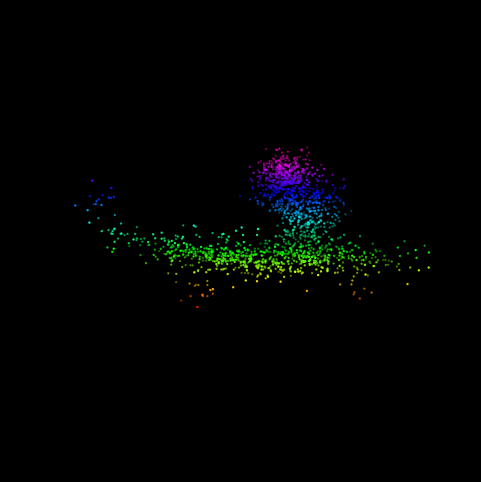

In [5]:
### Filter and plot all tracks in an XZ or YZ cross section
%matplotlib inline

tp = 0  # timepoint/cycle to plot

filelist = os.listdir(folder)
filelist = [file for file in filelist if file.endswith('.npy')]

file = os.path.join(folder, filelist[tp])
dataset = np.load(file)
print(file)

# get all (x,y,z) coodinates and plot them in a 3D scatter
loc_it = 4

x = np.zeros((len(dataset),1))
y = np.zeros((len(dataset),1))
z = np.zeros((len(dataset),1))
z1 = np.zeros((len(dataset),1))
tid = np.zeros((len(dataset),1))
tim = np.zeros((len(dataset),1))
efo = np.zeros((len(dataset),1))
for i in range(len(dataset)):
    x[i] = dataset[i][0][loc_it][2][0]
    y[i] = dataset[i][0][loc_it][2][1]
    z[i] = dataset[i][0][loc_it][2][2]
    z1[i] = dataset[i][0][1][2][2]
    efo[i] = dataset[i][0][loc_it][6]
    tid[i] = dataset[i][4]
    tim[i] = dataset[i][3]
x = x * 1e6
x = x.flatten()
y = y * 1e6
y = y.flatten()
z = z * 1e6
z = z * 0.7  # z scaling for immersion mismatch
z = z.flatten()
z1 = z1 * 1e6
z1 = z1.flatten()
tid = tid.flatten()
tim = tim.flatten()
efo = efo.flatten()
track_ids = list(map(int, set(tid)))
track_ids.sort()
data_df = pd.DataFrame(columns=['tridx', 'tim0', 'x', 'y', 'z', 'tim', 'dt', 'efo', 'lims', 'z1', 'z1_diff', 'z_std', 'z_range'])
for track in track_ids[::]:
    data_row = []
    x_track = np.array([val for val,tr in zip(x,tid) if tr==track]).flatten()
    y_track = np.array([val for val,tr in zip(y,tid) if tr==track]).flatten()
    z_track = np.array([val for val,tr in zip(z,tid) if tr==track]).flatten()
    z1_track = np.array([val for val,tr in zip(z1,tid) if tr==track]).flatten()
    tim_track = np.array([val for val,tr in zip(tim,tid) if tr==track]).flatten()
    efo_track = np.array([val for val,tr in zip(efo,tid) if tr==track]).flatten()
    z_diff = z_track - z1_track[0]
    data_row.append(track)
    data_row.append(tim_track[0])
    data_row.append(x_track)
    data_row.append(y_track)
    data_row.append(z_track)
    tim_track = tim_track - tim_track[0]
    data_row.append(tim_track)
    data_row.append(np.diff(tim_track))
    data_row.append(efo_track)
    data_row.append([np.min(x), np.max(x), np.min(y), np.max(y), np.min(z), np.max(z)])
    data_row.append(z1_track)
    data_row.append(z_diff)
    data_row.append(np.std(z_track))
    data_row.append(np.max(z_track)-np.min(z_track))
    data_df = pd.concat([data_df, pd.DataFrame([data_row], columns=data_df.columns)], ignore_index=True)

zstds = []
zspans = []
max_efo = 0
max_tim = 0
max_dt = 0

fig1 = plt.figure(figsize=(20,6))
ax1 = fig1.add_subplot(1,1,1,projection='3d')
trs = np.arange(0,len(data_df))
for tr in trs:
    dt_track_full = np.array(data_df.iloc[tr]['dt'])*1e6
    dt_track_full = np.insert(dt_track_full,0,0)
    if len(dt_track_full) > window_pts:
        local_dt_full = []
        for i in np.arange(0, len(dt_track_full)):
            if i > int(window_pts/2) and i < len(dt_track_full)-int(window_pts/2)-1:
                local_dt_full.append(np.mean(dt_track_full[i-int(window_pts/2):i+int(window_pts/2)]))
            else:
                local_dt_full.append(np.nan)
        local_dt_full = np.array(local_dt_full)
        idx_lists = consecutive_bool(np.argwhere(local_dt_full<dt_loc_thresh).flatten())
        # loop through all accepted tracks
        for idx_list in idx_lists:
            dt_track = dt_track_full[idx_list]
            if len(dt_track) > len_lim:
                x_track = data_df.iloc[tr]['x'][idx_list]
                y_track = data_df.iloc[tr]['y'][idx_list]
                z_track = data_df.iloc[tr]['z'][idx_list]
                tim_track = data_df.iloc[tr]['tim'][idx_list]
                efo_track = data_df.iloc[tr]['efo'][idx_list]
                y_track = y_track[np.abs(x_track-11.2)<0.05]
                z_track = z_track[np.abs(x_track-11.2)<0.05]
                x_track = x_track[np.abs(x_track-11.2)<0.05]

                if np.max(efo_track) > max_efo:
                    max_efo = np.max(efo_track)
                if np.max(dt_track) > max_dt:
                    max_dt = np.max(dt_track)
                if np.max(tim_track) > max_tim:
                    max_tim = np.max(tim_track)

                local_efo = []
                for i in np.arange(0, len(efo_track)):
                    if i > int(window_pts/2) and i < len(dt_track)-int(window_pts/2)-1:
                        local_efo.append(np.mean(efo_track[i-int(window_pts/2):i+int(window_pts/2)]))
                    else:
                        local_efo.append(np.nan)

                sc = ax1.scatter(x_track,y_track,z_track,c=z_track,cmap=cm.gist_rainbow, vmin=-0.1,vmax=0.1,s=0.5)
ax1.view_init(0, 0)
plt.axis('scaled')
ax1.set_zlim3d([-0.12,0.12])
ax1.set_xlim3d([11.0,11.3])
ax1.set_ylim3d([2.95,3.4])
ax1.set_box_aspect([ub - lb for lb, ub in (getattr(ax1, f'get_{a}lim')() for a in 'xyz')])
ax1.grid(False)
ax1.set_axis_off()
plt.style.use('dark_background')
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_zlabel('z')
ax1.xaxis.pane.fill = False
ax1.yaxis.pane.fill = False
ax1.zaxis.pane.fill = False

plt.show()

In [6]:
eventfolders = [os.path.join(parentdir, 'exampledata\\dyn1\\241101\\sample1\\cell2\\e1')]
folder = eventfolders[0]
roi_texts = ['ROI0']

Timepoint: 0
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102442_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1958572004.py:159: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc.get_cmap(), norm=sc.norm), label='z [um]');
C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1958572004.py:196: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc2.get_cmap(), norm=sc2.norm), label='z [um]');


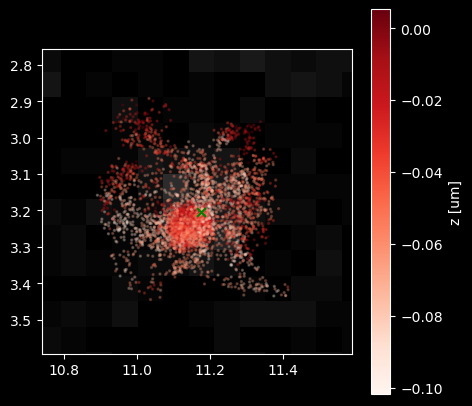

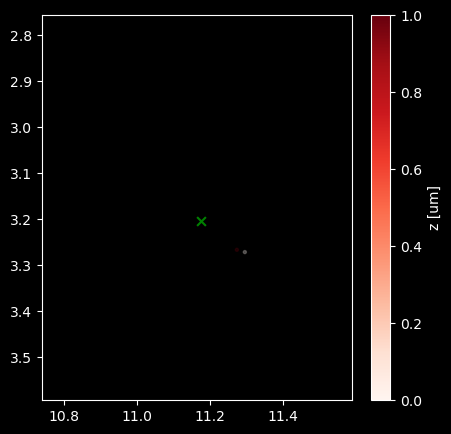

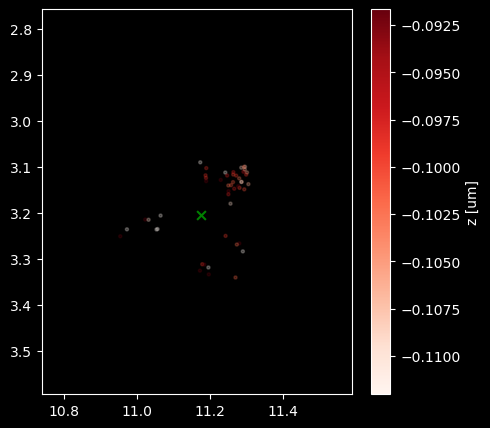

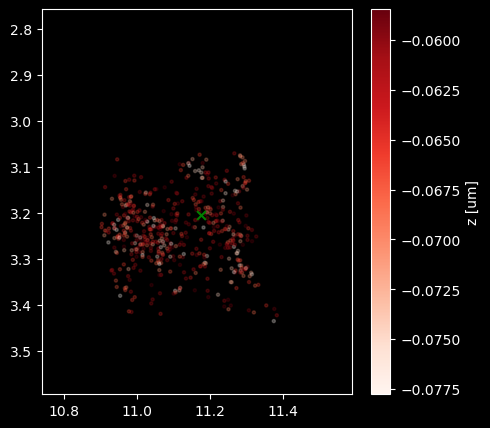

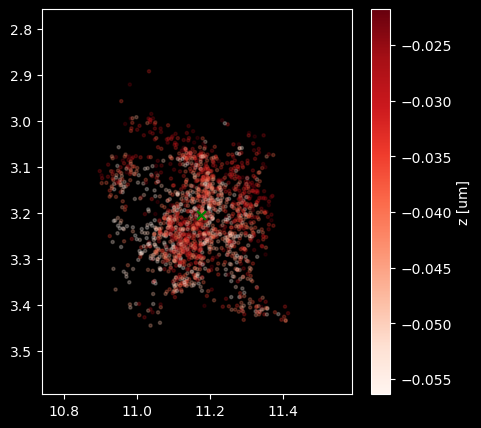

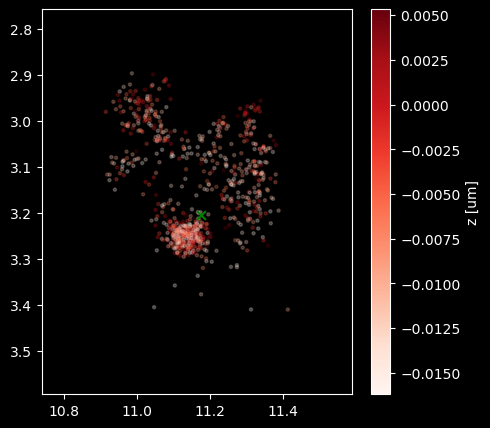

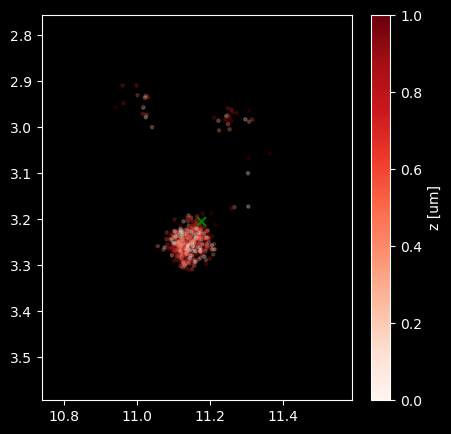

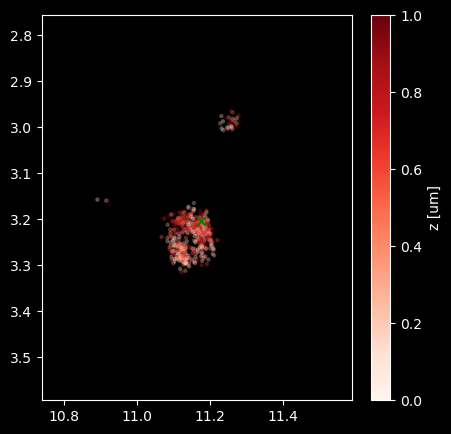

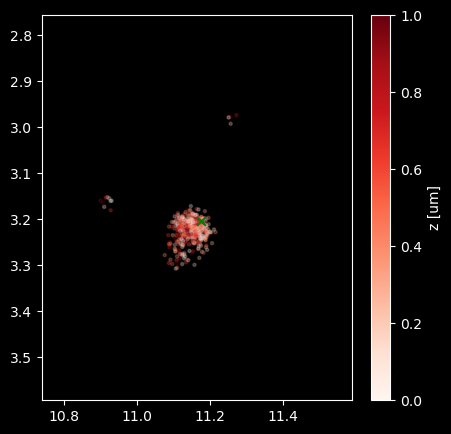

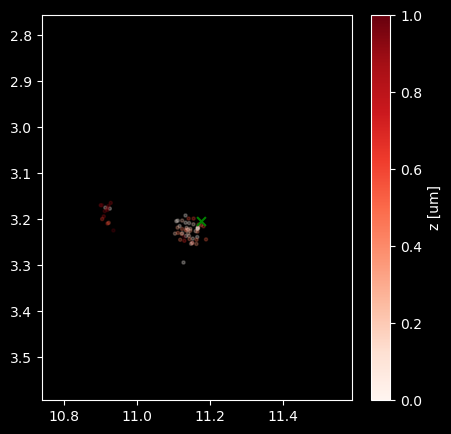

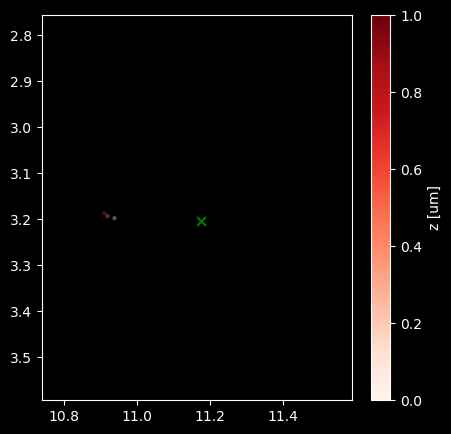

Timepoint: 1
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102514_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1958572004.py:159: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc.get_cmap(), norm=sc.norm), label='z [um]');
C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1958572004.py:196: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc2.get_cmap(), norm=sc2.norm), label='z [um]');


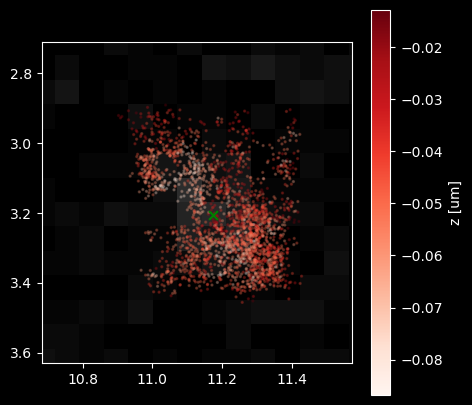

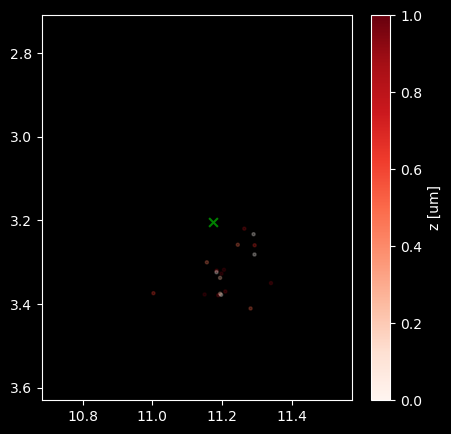

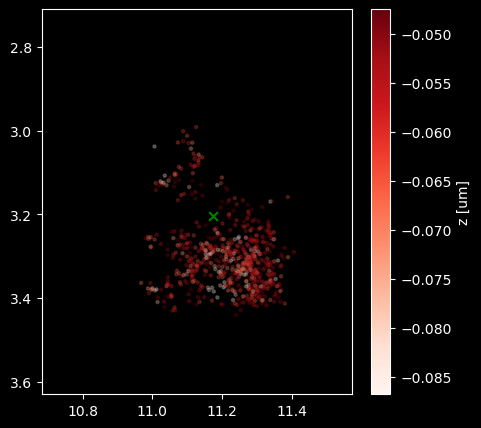

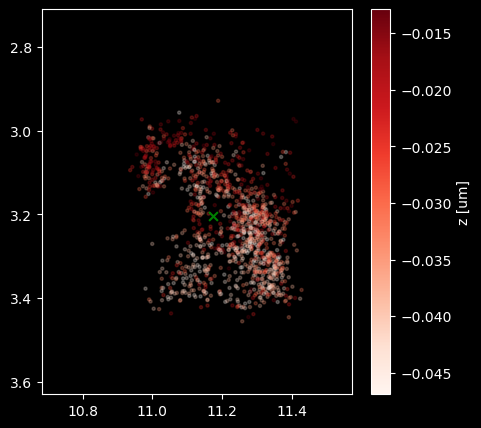

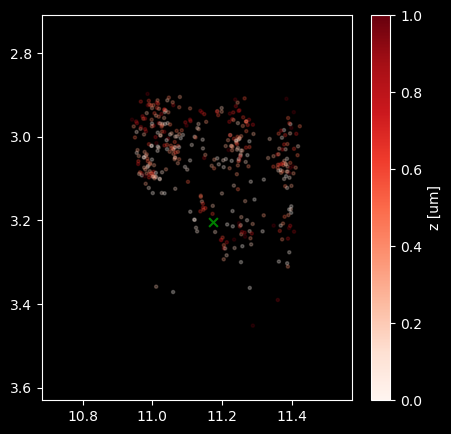

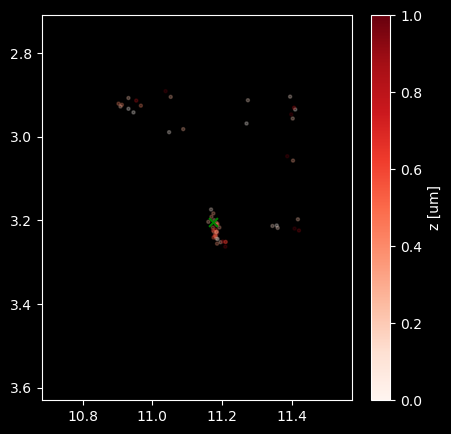

Timepoint: 2
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102546_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1958572004.py:159: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc.get_cmap(), norm=sc.norm), label='z [um]');
C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1958572004.py:196: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc2.get_cmap(), norm=sc2.norm), label='z [um]');


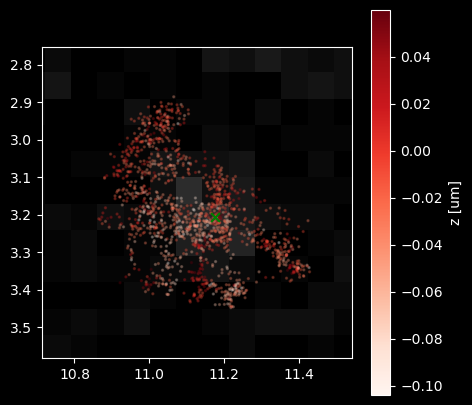

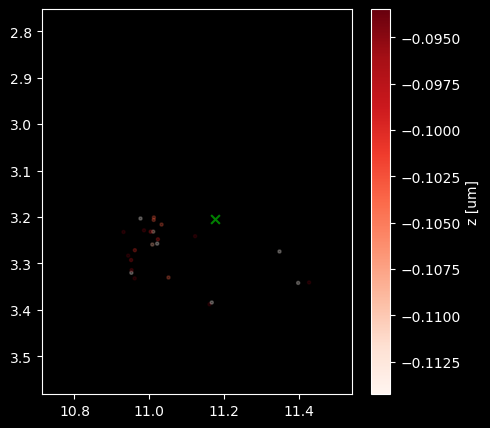

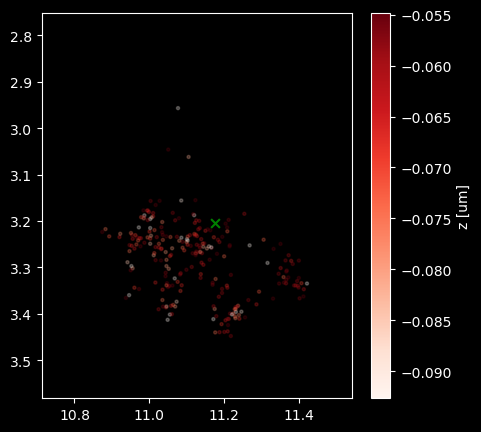

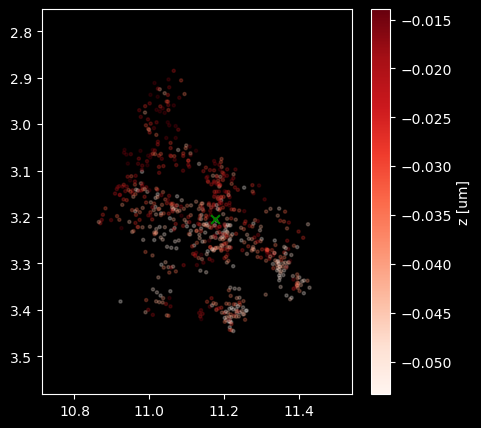

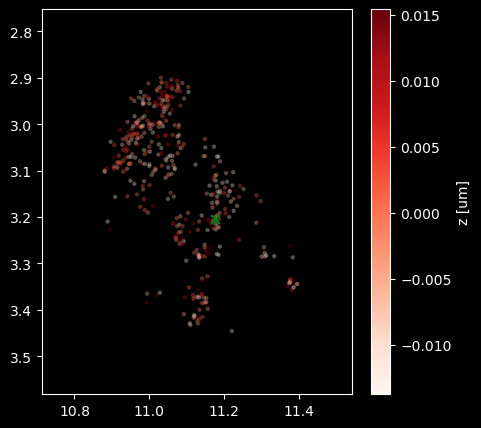

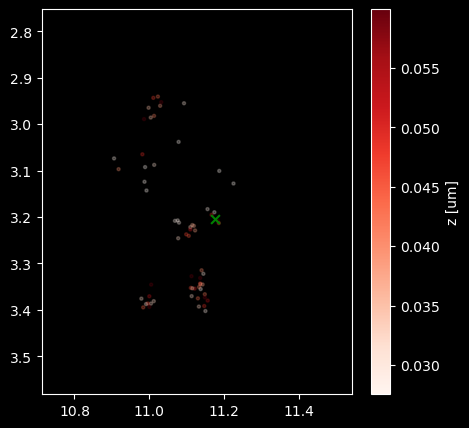

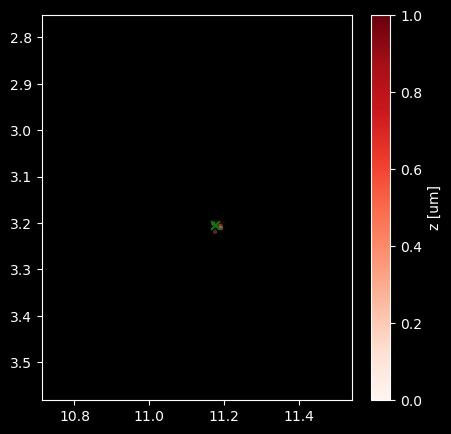

Timepoint: 3
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102618_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1958572004.py:159: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc.get_cmap(), norm=sc.norm), label='z [um]');
C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1958572004.py:196: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc2.get_cmap(), norm=sc2.norm), label='z [um]');


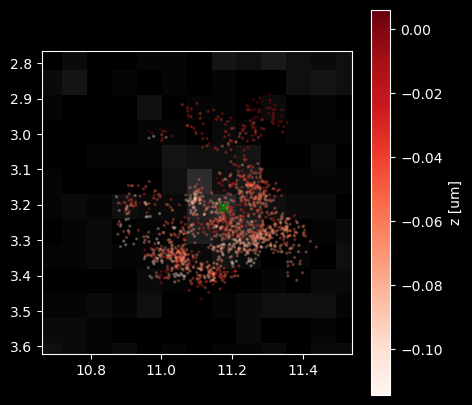

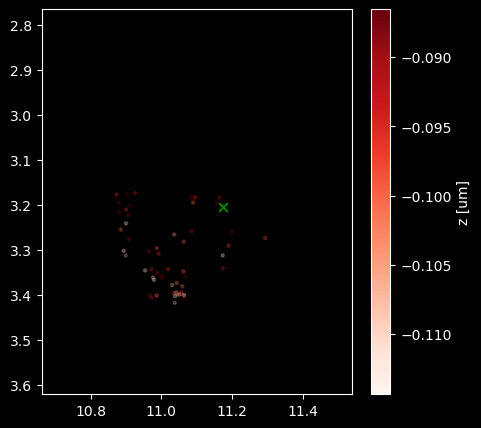

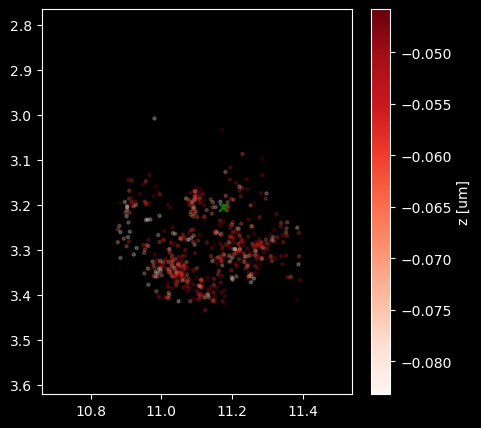

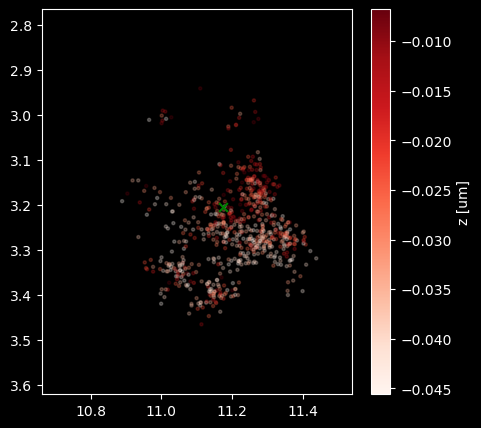

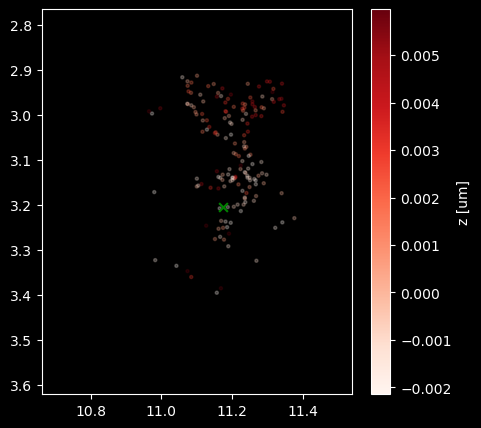

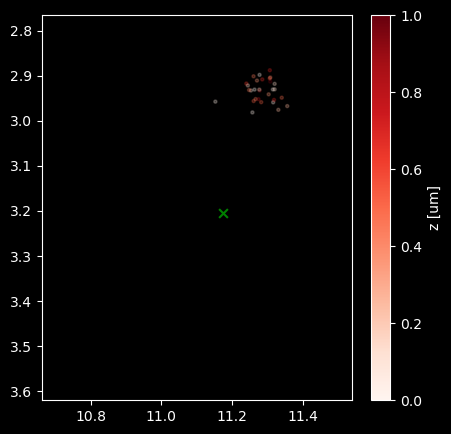

Timepoint: 4
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102649_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1958572004.py:159: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc.get_cmap(), norm=sc.norm), label='z [um]');
C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1958572004.py:196: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc2.get_cmap(), norm=sc2.norm), label='z [um]');


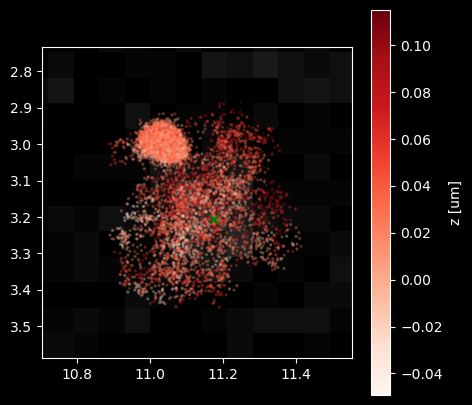

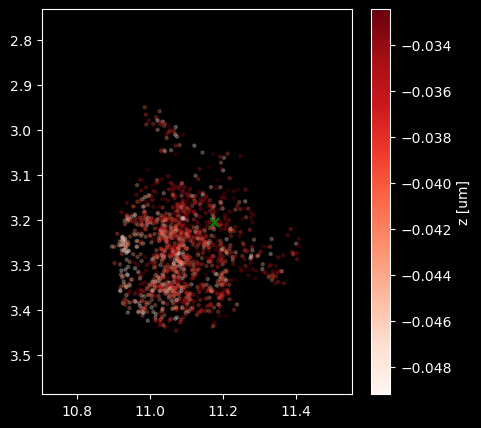

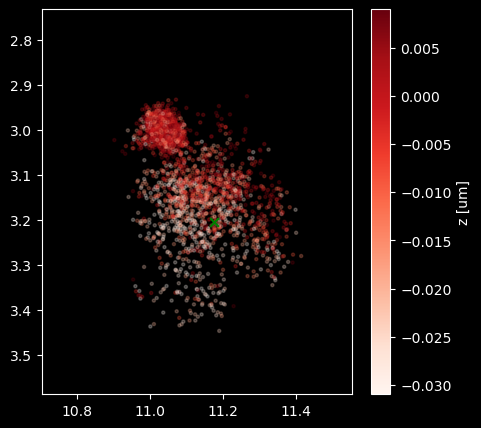

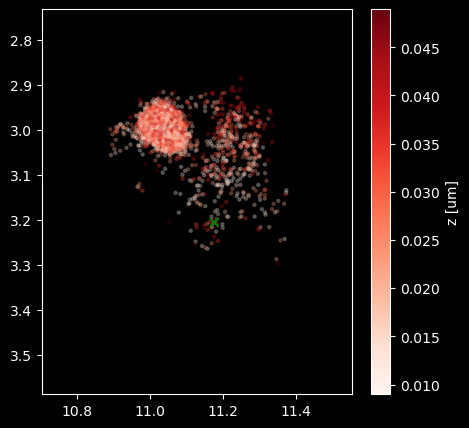

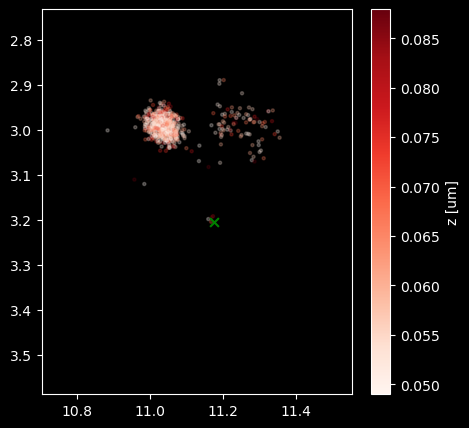

Timepoint: 5
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102721_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1958572004.py:159: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc.get_cmap(), norm=sc.norm), label='z [um]');
C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1958572004.py:196: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc2.get_cmap(), norm=sc2.norm), label='z [um]');


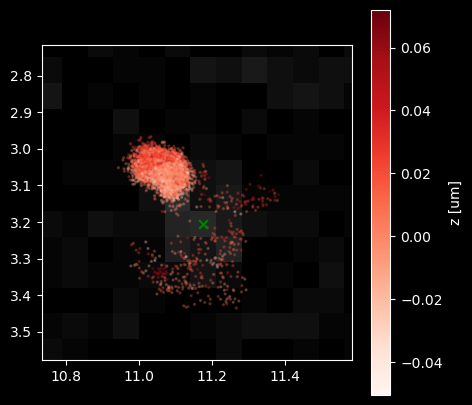

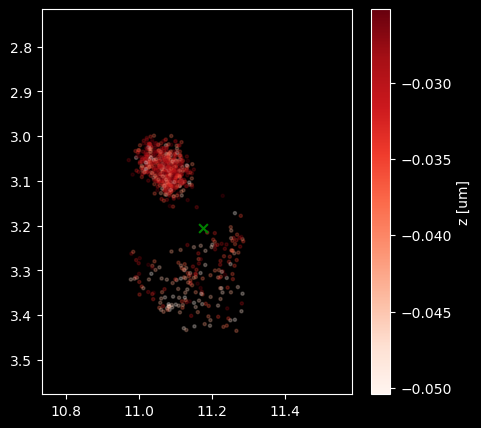

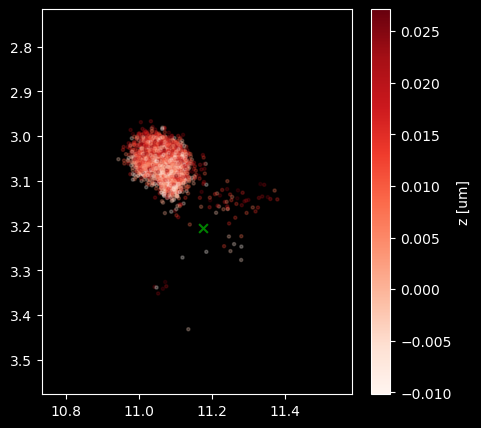

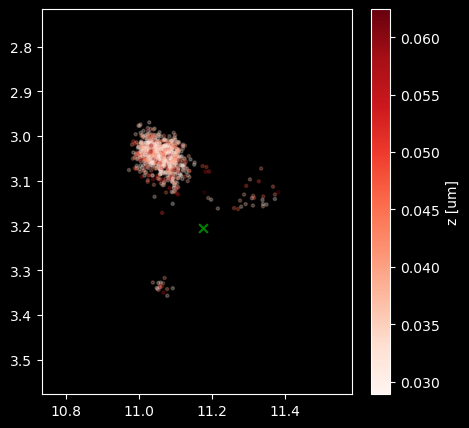

Timepoint: 6
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102753_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1958572004.py:159: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc.get_cmap(), norm=sc.norm), label='z [um]');
C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1958572004.py:196: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc2.get_cmap(), norm=sc2.norm), label='z [um]');


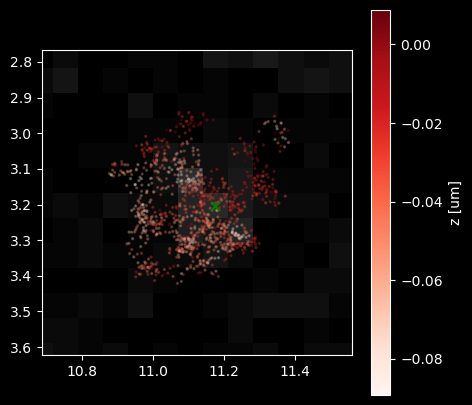

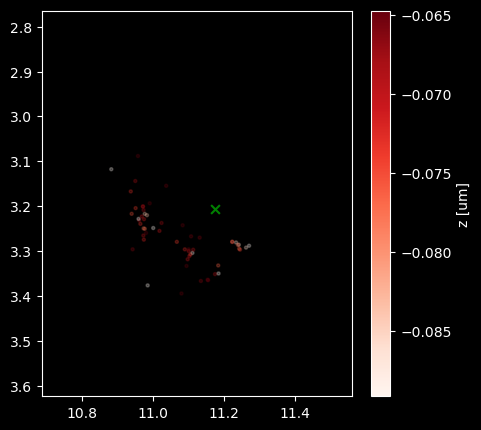

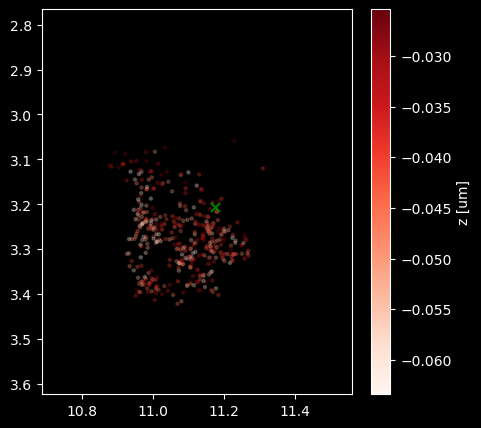

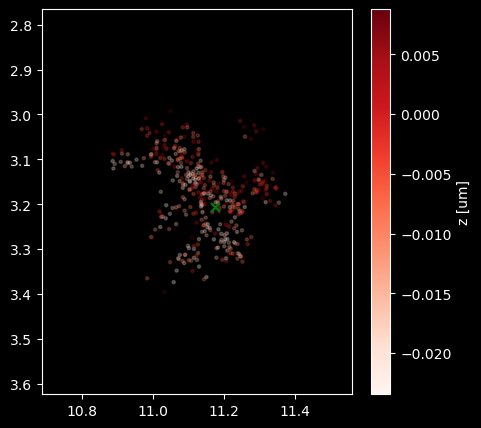

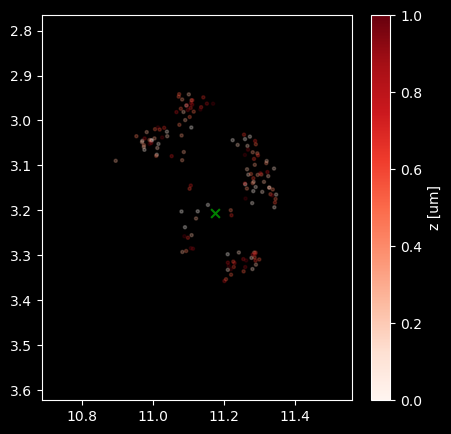

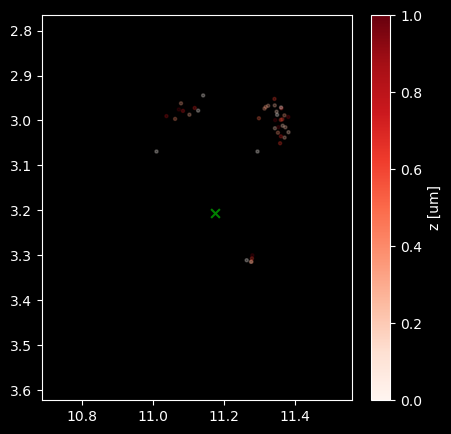

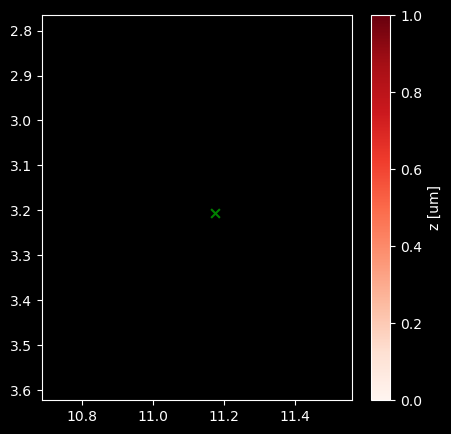

Timepoint: 7
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102824_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1958572004.py:159: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc.get_cmap(), norm=sc.norm), label='z [um]');
C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1958572004.py:196: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc2.get_cmap(), norm=sc2.norm), label='z [um]');


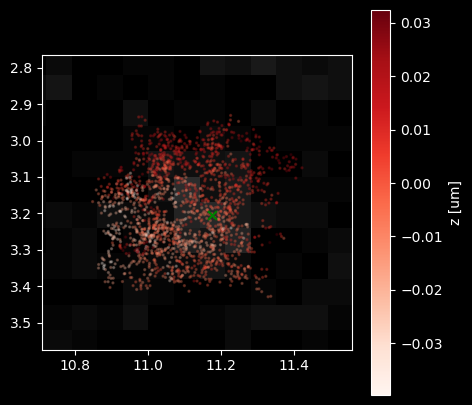

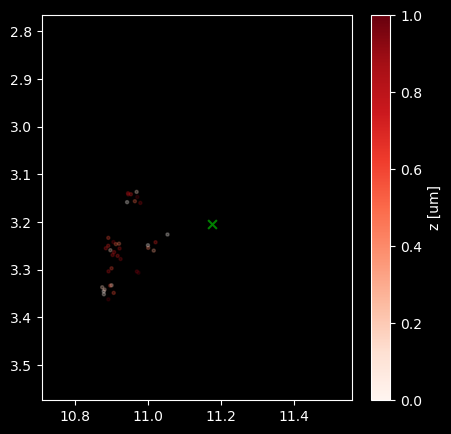

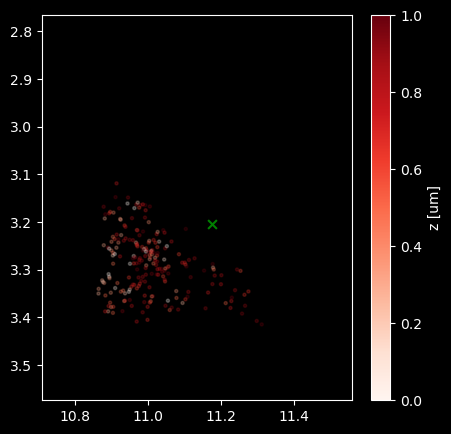

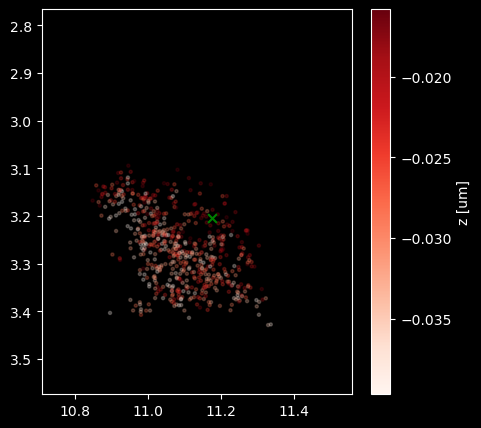

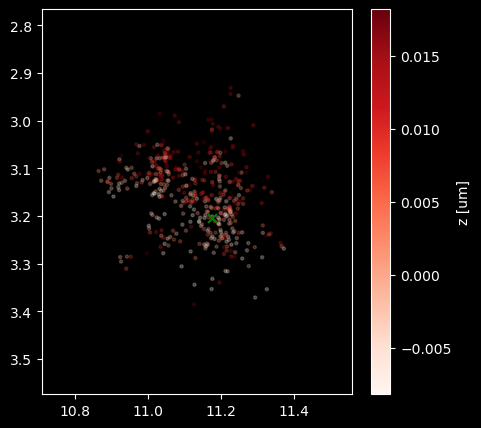

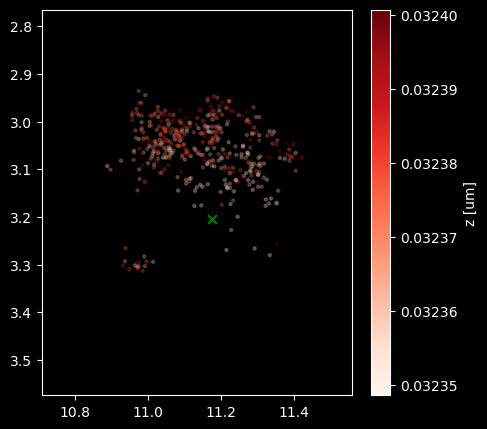

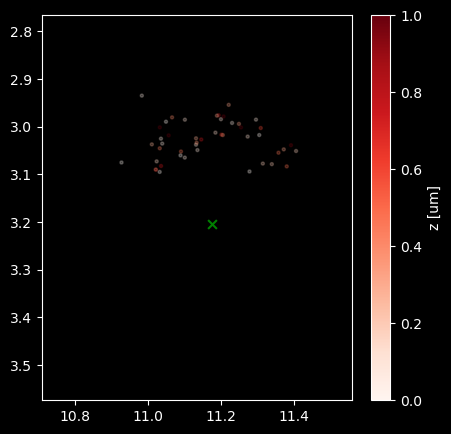

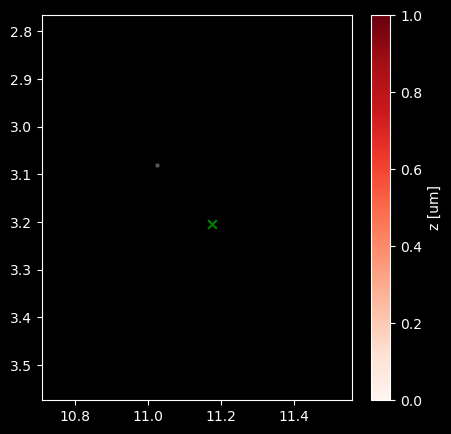

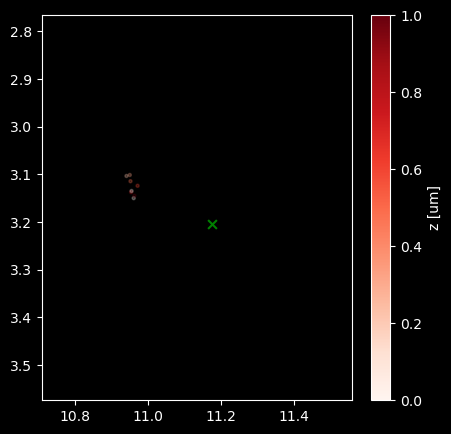

In [12]:
### Filter and plot all tracks in 2D, in different z-sections
#%matplotlib agg
#%matplotlib agg
%matplotlib inline

for roi_text in roi_texts:
    filelist = os.listdir(folder)
    filelist_npy = [file for file in filelist if file.endswith('.npy')]
    filelist_npy = [file for file in filelist_npy if roi_text+'-' in file and 'test' not in file]
    filelist_rawtif = [file for file in filelist if file.endswith('.tif') and 'raw' in file]
    filelist_msr = [file for file in filelist if file.endswith('.msr')]

    file_idx_msr_conf = 0

    # load msr file to read confocal image settings
    # get metadata from confocal image in msr file (pixel size, image shape, image size, origin offset)
    file_msr = os.path.join(folder, filelist_msr[file_idx_msr_conf])
    msr_dataset = obf_support.File(file_msr)
    conf_msr_stack_index = 0
    conf_stack = msr_dataset.stacks[conf_msr_stack_index]
    pxsize = conf_stack.pixel_sizes[0]*1e6
    pxshift = pxsize/2
    conf_size_px = (conf_stack.shape[0], conf_stack.shape[1])
    conf_size = (conf_stack.lengths[0]*1e6, conf_stack.lengths[1]*1e6)
    conf_offset = (conf_stack.offsets[0]*1e6, conf_stack.offsets[1]*1e6)

    # load confocal image and imshow it
    file_rawtif = os.path.join(folder, filelist_rawtif[file_idx_msr_conf])
    conf_stack = tiff.imread(file_rawtif)
    conf_img = conf_stack[-1]

    for file_idx_npy in range(len(filelist_npy)):
        print(f'Timepoint: {file_idx_npy}')
        fig1 = plt.figure(figsize=(5,5))
        ax1 = fig1.add_subplot(111)

        conf_imgax = ax1.imshow(conf_img, cmap='gray', alpha=1)
        extents_confimg = np.array(conf_imgax.get_extent())*pxsize+[pxsize/2, pxsize/2, pxsize/2, pxsize/2]+[conf_offset[0], conf_offset[0], conf_offset[1], conf_offset[1]]
        conf_imgax.set_extent(extents_confimg)  # scale overlay image to the correct pixel size for the tracks

        file_npy = os.path.join(folder, filelist_npy[file_idx_npy])
        dataset = np.load(file_npy)
        print(file_npy)

        # get all (x,y,z) coodinates and plot them in a 2D scatter
        loc_it = 4

        x = np.zeros((len(dataset),1))
        y = np.zeros((len(dataset),1))
        z = np.zeros((len(dataset),1))
        z1 = np.zeros((len(dataset),1))
        tid = np.zeros((len(dataset),1))
        tim = np.zeros((len(dataset),1))
        efo = np.zeros((len(dataset),1))
        for i in range(len(dataset)):
            x[i] = dataset[i][0][loc_it][2][0]
            y[i] = dataset[i][0][loc_it][2][1]
            z[i] = dataset[i][0][loc_it][2][2]
            z1[i] = dataset[i][0][1][2][2]
            efo[i] = dataset[i][0][loc_it][6]
            tid[i] = dataset[i][4]
            tim[i] = dataset[i][3]
        x = x * 1e6
        x = x.flatten()
        xlim = [np.min(x)-0.1, np.max(x)+0.1]
        y = y * 1e6
        y = y.flatten()
        ylim = [np.min(y)-0.1, np.max(y)+0.1]
        z = z * 1e6
        z = z.flatten()
        z1 = z1 * 1e6
        z1 = z1.flatten()
        tid = tid.flatten()
        tim = tim.flatten()
        efo = efo.flatten()
        track_ids = list(map(int, set(tid)))
        track_ids.sort()
        data_df = pd.DataFrame(columns=['tridx', 'tim0', 'x', 'y', 'z', 'tim', 'dt', 'efo', 'lims', 'z1', 'z1_diff', 'z_std', 'z_range'])
        for track in track_ids[::]:
            data_row = []
            x_track = np.array([val for val,tr in zip(x,tid) if tr==track]).flatten()
            y_track = np.array([val for val,tr in zip(y,tid) if tr==track]).flatten()
            z_track = np.array([val for val,tr in zip(z,tid) if tr==track]).flatten()
            z1_track = np.array([val for val,tr in zip(z1,tid) if tr==track]).flatten()
            tim_track = np.array([val for val,tr in zip(tim,tid) if tr==track]).flatten()
            efo_track = np.array([val for val,tr in zip(efo,tid) if tr==track]).flatten()
            z_diff = z_track - z1_track[0]
            data_row.append(track)
            data_row.append(tim_track[0])
            data_row.append(x_track)
            data_row.append(y_track)
            data_row.append(z_track)
            tim_track = tim_track - tim_track[0]
            data_row.append(tim_track)
            data_row.append(np.diff(tim_track))
            data_row.append(efo_track)
            data_row.append([np.min(x), np.max(x), np.min(y), np.max(y), np.min(z), np.max(z)])
            data_row.append(z1_track)
            data_row.append(z_diff)
            data_row.append(np.std(z_track))
            data_row.append(np.max(z_track)-np.min(z_track))
            data_df = pd.concat([data_df, pd.DataFrame([data_row], columns=data_df.columns)], ignore_index=True)

        zstds = []
        zspans = []
        max_efo = 0
        max_tim = 0
        max_dt = 0

        trs = np.arange(0,len(data_df))
        for tr in trs:
            dt_track_full = np.array(data_df.iloc[tr]['dt'])*1e6
            dt_track_full = np.insert(dt_track_full,0,0)
            if len(dt_track_full) > window_pts:
                local_dt_full = []
                for i in np.arange(0, len(dt_track_full)):
                    if i > int(window_pts/2) and i < len(dt_track_full)-int(window_pts/2)-1:
                        local_dt_full.append(np.mean(dt_track_full[i-int(window_pts/2):i+int(window_pts/2)]))
                    else:
                        local_dt_full.append(np.nan)
                local_dt_full = np.array(local_dt_full)
                idx_lists = consecutive_bool(np.argwhere(local_dt_full<dt_loc_thresh).flatten())
                # loop through all accepted tracks
                for idx_list in idx_lists:
                    dt_track = dt_track_full[idx_list]
                    if len(dt_track) > len_lim:
                        x_track = data_df.iloc[tr]['x'][idx_list]
                        y_track = data_df.iloc[tr]['y'][idx_list]
                        z_track = data_df.iloc[tr]['z'][idx_list]
                        tim_track = data_df.iloc[tr]['tim'][idx_list]
                        efo_track = data_df.iloc[tr]['efo'][idx_list]
                        local_dt = local_dt_full[idx_list]
                        z1_track = data_df.iloc[tr]['z1'][idx_list]
                        z1diff_track = data_df.iloc[tr]['z1_diff'][idx_list]
                        zstd = np.std(z_track)
                        zspan = np.max(z_track)-np.min(z_track)
                        zstds.append(zstd)
                        zspans.append(zspan)

                        if np.max(efo_track) > max_efo:
                            max_efo = np.max(efo_track)
                        if np.max(dt_track) > max_dt:
                            max_dt = np.max(dt_track)
                        if np.max(tim_track) > max_tim:
                            max_tim = np.max(tim_track)

                        local_efo = []
                        for i in np.arange(0, len(efo_track)):
                            if i > int(window_pts/2) and i < len(dt_track)-int(window_pts/2)-1:
                                local_efo.append(np.mean(efo_track[i-int(window_pts/2):i+int(window_pts/2)]))
                            else:
                                local_efo.append(np.nan)

                        sc = ax1.scatter(x_track, y_track, c=z_track, cmap='Reds', s=2, alpha=0.25, rasterized=True)

        # plot event coordinates
        roi_pos = (int(file_npy.split('[')[1].split(',')[0]),int(file_npy.split(']')[0].split(',')[1]))
        plt.scatter(roi_pos[0]*pxsize+pxsize/2+conf_offset[0], roi_pos[1]*pxsize+pxsize/2+conf_offset[1], marker='x', color='green', s=40)
        plt.colorbar(ScalarMappable(cmap=sc.get_cmap(), norm=sc.norm), label='z [um]');
        plt.xlim(*xlim)
        plt.ylim(*ylim)
        plt.gca().invert_yaxis()

        zrange = (np.mean(z)-np.std(z)*stdfact, np.mean(z)+np.std(z)*stdfact)
        for zmin in np.arange(zrange[0],zrange[1],zstep):
            zmax = zmin+zstep
            fig2 = plt.figure(figsize=(5,5))
            ax2 = fig2.add_subplot(111)
            trs = np.arange(0,len(data_df))
            for tr in trs:
                dt_track_full = np.array(data_df.iloc[tr]['dt'])*1e6
                dt_track_full = np.insert(dt_track_full,0,0)
                if len(dt_track_full) > window_pts:
                    local_dt_full = []
                    for i in np.arange(0, len(dt_track_full)):
                        if i > int(window_pts/2) and i < len(dt_track_full)-int(window_pts/2)-1:
                            local_dt_full.append(np.mean(dt_track_full[i-int(window_pts/2):i+int(window_pts/2)]))
                        else:
                            local_dt_full.append(np.nan)
                    local_dt_full = np.array(local_dt_full)
                    idx_lists = consecutive_bool(np.argwhere(local_dt_full<dt_loc_thresh).flatten())
                    # loop through all accepted tracks
                    for idx_list in idx_lists:
                        dt_track = dt_track_full[idx_list]
                        if len(dt_track) > len_lim:
                            x_track = data_df.iloc[tr]['x'][idx_list]
                            y_track = data_df.iloc[tr]['y'][idx_list]
                            z_track = data_df.iloc[tr]['z'][idx_list]

                            z_mask = np.logical_and(z_track > zmin, z_track < zmax)

                            sc2 = ax2.scatter(x_track[z_mask], y_track[z_mask], c=z_track[z_mask], cmap='Reds', s=5, alpha=0.25, rasterized=True)

            roi_pos = (int(file_npy.split('[')[1].split(',')[0]),int(file_npy.split(']')[0].split(',')[1]))
            plt.scatter(roi_pos[0]*pxsize+pxsize/2+conf_offset[0], roi_pos[1]*pxsize+pxsize/2+conf_offset[1], marker='x', color='green', s=40)
            plt.colorbar(ScalarMappable(cmap=sc2.get_cmap(), norm=sc2.norm), label='z [um]');
            plt.xlim(*xlim)
            plt.ylim(*ylim)
            plt.gca().invert_yaxis()
        plt.show()
        #pdf = mpl.backends.backend_pdf.PdfPages(os.path.join(folder,f"plot-3Dzslicing-{roi_text}-cycle{file_idx_npy}.pdf"))
        #for i in plt.get_fignums():
        #    pdf.savefig(i)
        #pdf.close()
        #plt.close('all')

Timepoint: 0
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102442_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\1076683001.py:162: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc.get_cmap(), norm=sc.norm), label='z [um]')


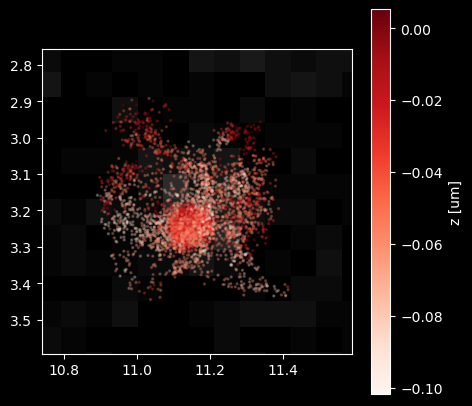

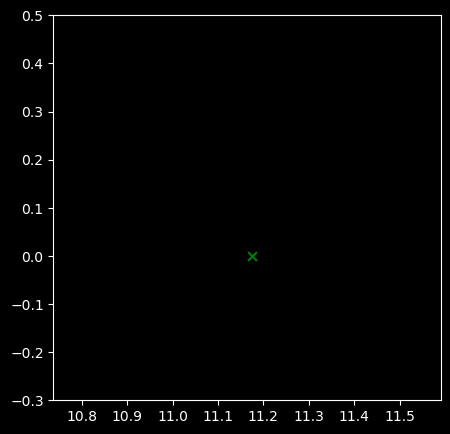

Timepoint: 1
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102514_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


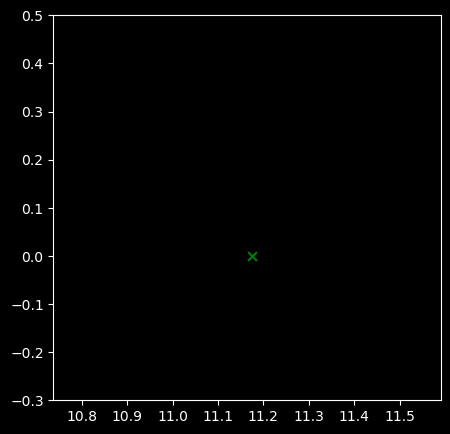

Timepoint: 2
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102546_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


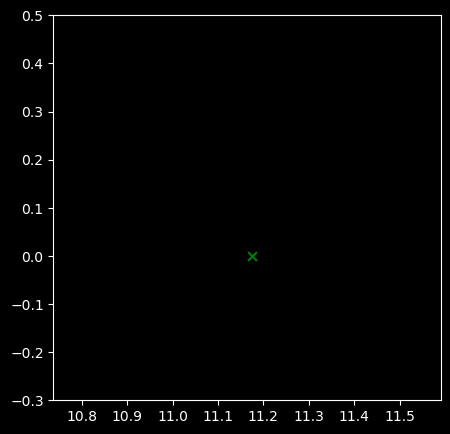

Timepoint: 3
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102618_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


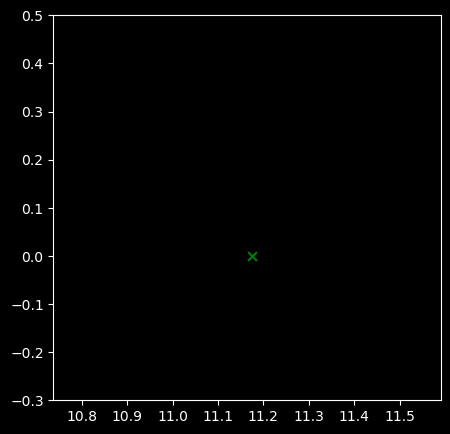

Timepoint: 4
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102649_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


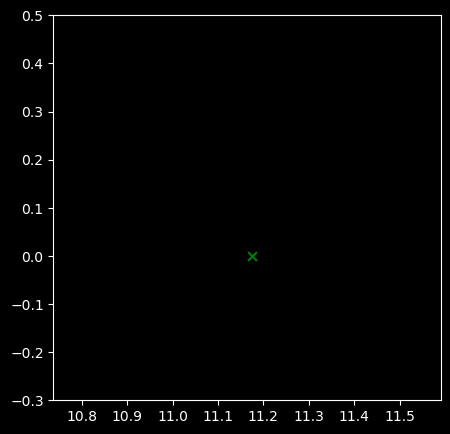

Timepoint: 5
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102721_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


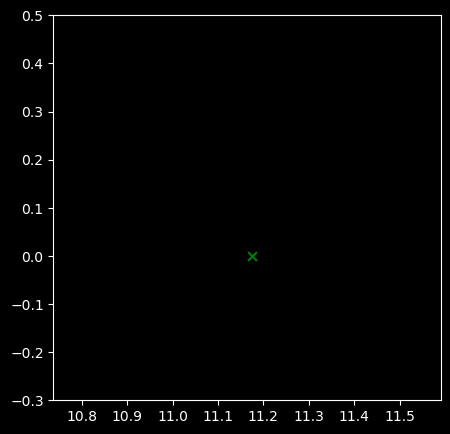

Timepoint: 6
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102753_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


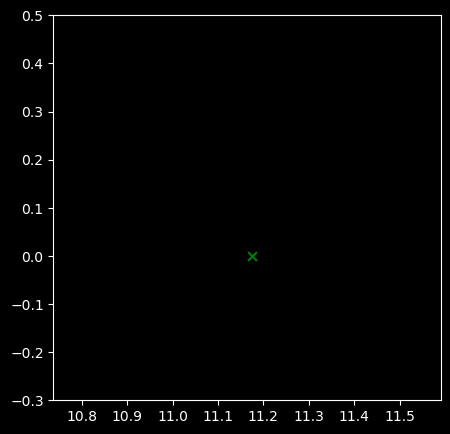

Timepoint: 7
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102824_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


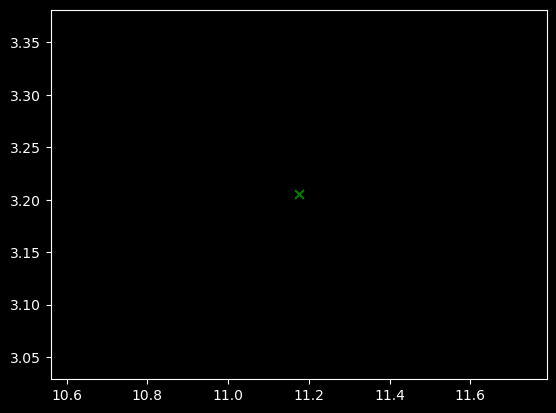

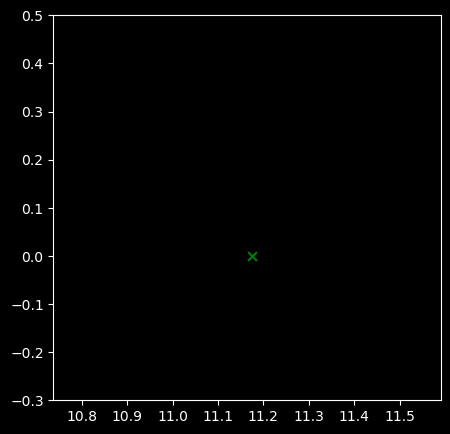

In [13]:
### Filter and plot all tracks in 2D, in xz-section across site position
#%matplotlib agg
#%matplotlib agg
%matplotlib inline

for roi_text in roi_texts:
    filelist = os.listdir(folder)
    filelist_npy = [file for file in filelist if file.endswith('.npy')]
    filelist_npy = [file for file in filelist_npy if roi_text+'-' in file]
    filelist_rawtif = [file for file in filelist if file.endswith('.tif') and 'raw' in file]
    filelist_msr = [file for file in filelist if file.endswith('.msr')]

    file_idx_msr_conf = 0

    # load msr file to read confocal image settings
    # get metadata from confocal image in msr file (pixel size, image shape, image size, origin offset)
    file_msr = os.path.join(folder, filelist_msr[file_idx_msr_conf])
    msr_dataset = obf_support.File(file_msr)
    conf_msr_stack_index = 0
    conf_stack = msr_dataset.stacks[conf_msr_stack_index]
    pxsize = conf_stack.pixel_sizes[0]*1e6
    pxshift = pxsize/2
    conf_size_px = (conf_stack.shape[0], conf_stack.shape[1])
    conf_size = (conf_stack.lengths[0]*1e6, conf_stack.lengths[1]*1e6)
    conf_offset = (conf_stack.offsets[0]*1e6, conf_stack.offsets[1]*1e6)

    # load confocal image and imshow it
    file_rawtif = os.path.join(folder, filelist_rawtif[file_idx_msr_conf])
    conf_stack = tiff.imread(file_rawtif)
    conf_img = conf_stack[-1]

    fig1 = plt.figure(figsize=(5,5))
    ax1 = fig1.add_subplot(111)

    conf_imgax = ax1.imshow(conf_img, cmap='gray', alpha=1)
    extents_confimg = np.array(conf_imgax.get_extent())*pxsize+[pxsize/2, pxsize/2, pxsize/2, pxsize/2]+[conf_offset[0], conf_offset[0], conf_offset[1], conf_offset[1]]
    conf_imgax.set_extent(extents_confimg)  # scale overlay image to the correct pixel size for the tracks

    file_idx_npy = 0
    for file_idx_npy in range(len(filelist_npy)):
        print(f'Timepoint: {file_idx_npy}')
        file_npy = os.path.join(folder, filelist_npy[file_idx_npy])
        dataset = np.load(file_npy)
        print(file_npy)

        # get all (x,y,z) coodinates and plot them in a 2D scatter
        loc_it = 4

        x = np.zeros((len(dataset),1))
        y = np.zeros((len(dataset),1))
        z = np.zeros((len(dataset),1))
        z1 = np.zeros((len(dataset),1))
        tid = np.zeros((len(dataset),1))
        tim = np.zeros((len(dataset),1))
        efo = np.zeros((len(dataset),1))
        for i in range(len(dataset)):
            x[i] = dataset[i][0][loc_it][2][0]
            y[i] = dataset[i][0][loc_it][2][1]
            z[i] = dataset[i][0][loc_it][2][2]
            z1[i] = dataset[i][0][1][2][2]
            efo[i] = dataset[i][0][loc_it][6]
            tid[i] = dataset[i][4]
            tim[i] = dataset[i][3]
        x = x * 1e6
        x = x.flatten()
        if file_idx_npy == 0:
            xlim = [np.min(x)-0.1, np.max(x)+0.1]
        y = y * 1e6
        y = y.flatten()
        if file_idx_npy == 0:
            ylim = [np.min(y)-0.1, np.max(y)+0.1]
        z = z * 1e6
        z = z.flatten()
        z1 = z1 * 1e6
        z1 = z1.flatten()
        tid = tid.flatten()
        tim = tim.flatten()
        efo = efo.flatten()
        track_ids = list(map(int, set(tid)))
        track_ids.sort()
        data_df = pd.DataFrame(columns=['tridx', 'tim0', 'x', 'y', 'z', 'tim', 'dt', 'efo', 'lims', 'z1', 'z1_diff', 'z_std', 'z_range'])
        for track in track_ids[::]:
            data_row = []
            x_track = np.array([val for val,tr in zip(x,tid) if tr==track]).flatten()
            y_track = np.array([val for val,tr in zip(y,tid) if tr==track]).flatten()
            z_track = np.array([val for val,tr in zip(z,tid) if tr==track]).flatten()
            z1_track = np.array([val for val,tr in zip(z1,tid) if tr==track]).flatten()
            tim_track = np.array([val for val,tr in zip(tim,tid) if tr==track]).flatten()
            efo_track = np.array([val for val,tr in zip(efo,tid) if tr==track]).flatten()
            z_diff = z_track - z1_track[0]
            data_row.append(track)
            data_row.append(tim_track[0])
            data_row.append(x_track)
            data_row.append(y_track)
            data_row.append(z_track)
            tim_track = tim_track - tim_track[0]
            data_row.append(tim_track)
            data_row.append(np.diff(tim_track))
            data_row.append(efo_track)
            data_row.append([np.min(x), np.max(x), np.min(y), np.max(y), np.min(z), np.max(z)])
            data_row.append(z1_track)
            data_row.append(z_diff)
            data_row.append(np.std(z_track))
            data_row.append(np.max(z_track)-np.min(z_track))
            data_df = pd.concat([data_df, pd.DataFrame([data_row], columns=data_df.columns)], ignore_index=True)

        zstds = []
        zspans = []
        max_efo = 0
        max_tim = 0
        max_dt = 0

        trs = np.arange(0,len(data_df))
        for tr in trs:
            dt_track_full = np.array(data_df.iloc[tr]['dt'])*1e6
            dt_track_full = np.insert(dt_track_full,0,0)
            if len(dt_track_full) > window_pts:
                local_dt_full = []
                for i in np.arange(0, len(dt_track_full)):
                    if i > int(window_pts/2) and i < len(dt_track_full)-int(window_pts/2)-1:
                        local_dt_full.append(np.mean(dt_track_full[i-int(window_pts/2):i+int(window_pts/2)]))
                    else:
                        local_dt_full.append(np.nan)
                local_dt_full = np.array(local_dt_full)
                idx_lists = consecutive_bool(np.argwhere(local_dt_full<dt_loc_thresh).flatten())
                # loop through all accepted tracks
                for idx_list in idx_lists:
                    dt_track = dt_track_full[idx_list]
                    if len(dt_track) > len_lim:
                        x_track = data_df.iloc[tr]['x'][idx_list]
                        y_track = data_df.iloc[tr]['y'][idx_list]
                        z_track = data_df.iloc[tr]['z'][idx_list]
                        tim_track = data_df.iloc[tr]['tim'][idx_list]
                        efo_track = data_df.iloc[tr]['efo'][idx_list]
                        local_dt = local_dt_full[idx_list]
                        z1_track = data_df.iloc[tr]['z1'][idx_list]
                        z1diff_track = data_df.iloc[tr]['z1_diff'][idx_list]
                        zstd = np.std(z_track)
                        zspan = np.max(z_track)-np.min(z_track)
                        zstds.append(zstd)
                        zspans.append(zspan)

                        if np.max(efo_track) > max_efo:
                            max_efo = np.max(efo_track)
                        if np.max(dt_track) > max_dt:
                            max_dt = np.max(dt_track)
                        if np.max(tim_track) > max_tim:
                            max_tim = np.max(tim_track)

                        local_efo = []
                        for i in np.arange(0, len(efo_track)):
                            if i > int(window_pts/2) and i < len(dt_track)-int(window_pts/2)-1:
                                local_efo.append(np.mean(efo_track[i-int(window_pts/2):i+int(window_pts/2)]))
                            else:
                                local_efo.append(np.nan)

                        sc = ax1.scatter(x_track, y_track, c=z_track, cmap='Reds', s=2, alpha=0.25, rasterized=True)

        if file_idx_npy == 0:
            # plot event coordinates
            roi_pos = (int(file_npy.split('[')[1].split(',')[0]),int(file_npy.split(']')[0].split(',')[1]))
            plt.colorbar(ScalarMappable(cmap=sc.get_cmap(), norm=sc.norm), label='z [um]')
            plt.xlim(*xlim)
            plt.ylim(*ylim)
            plt.gca().invert_yaxis()
        elif file_idx_npy == len(filelist_npy)-1:
            plt.scatter(roi_pos[0]*pxsize+pxsize/2+conf_offset[0], roi_pos[1]*pxsize+pxsize/2+conf_offset[1], marker='x', color='green', s=40)

        ypos = roi_pos[1]*pxsize+pxsize/2+conf_offset[1]
        fig2 = plt.figure(figsize=(5,5))
        ax2 = fig2.add_subplot(111)
        trs = np.arange(0,len(data_df))
        for tr in trs:
            dt_track_full = np.array(data_df.iloc[tr]['dt'])*1e6
            dt_track_full = np.insert(dt_track_full,0,0)
            if len(dt_track_full) > window_pts:
                local_dt_full = []
                for i in np.arange(0, len(dt_track_full)):
                    if i > int(window_pts/2) and i < len(dt_track_full)-int(window_pts/2)-1:
                        local_dt_full.append(np.mean(dt_track_full[i-int(window_pts/2):i+int(window_pts/2)]))
                    else:
                        local_dt_full.append(np.nan)
                local_dt_full = np.array(local_dt_full)
                idx_lists = consecutive_bool(np.argwhere(local_dt_full<dt_loc_thresh).flatten())
                # loop through all accepted tracks
                for idx_list in idx_lists:
                    dt_track = dt_track_full[idx_list]
                    if len(dt_track) > len_lim:
                        x_track = data_df.iloc[tr]['x'][idx_list]
                        y_track = data_df.iloc[tr]['y'][idx_list]
                        z_track = data_df.iloc[tr]['z'][idx_list]

                        y_mask = np.logical_and(y_track > ypos-ydepth, y_track < ypos+ydepth)

                        sc2 = ax2.scatter(x_track[y_mask], z_track[y_mask], color='k', s=5, alpha=0.25, rasterized=True)

        roi_pos = (int(file_npy.split('[')[1].split(',')[0]),int(file_npy.split(']')[0].split(',')[1]))
        plt.scatter(roi_pos[0]*pxsize+pxsize/2+conf_offset[0], 0, marker='x', color='green', s=40)
        plt.xlim(*xlim)
        plt.ylim([-0.3,0.5])
        plt.show()

    #pdf = matplotlib.backends.backend_pdf.PdfPages(os.path.join(folder,f"plot-3Dyslicing-{roi_text}.pdf"))
    #for i in plt.get_fignums():
    #    pdf.savefig(i)
    #pdf.close()
    #plt.close('all')

Timepoint: 0
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102442_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


C:\Users\alvelidjonatan\AppData\Local\Temp\ipykernel_21656\2458763933.py:161: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(ScalarMappable(cmap=sc.get_cmap(), norm=sc.norm), label='z [um]')


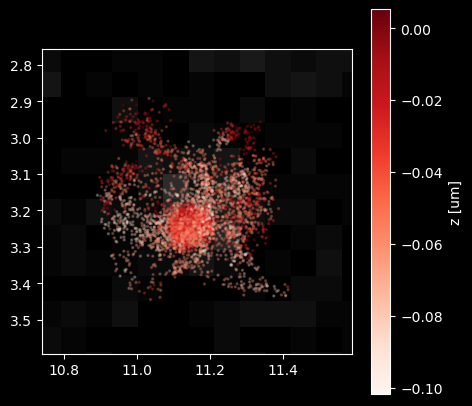

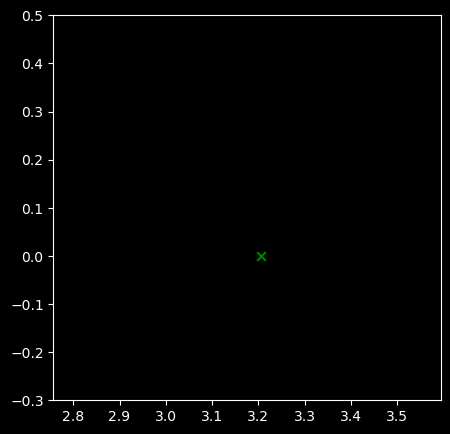

Timepoint: 1
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102514_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


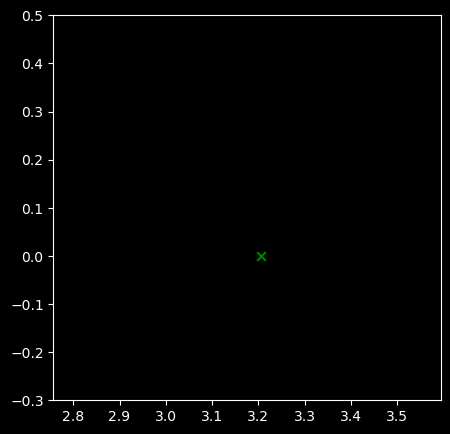

Timepoint: 2
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102546_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


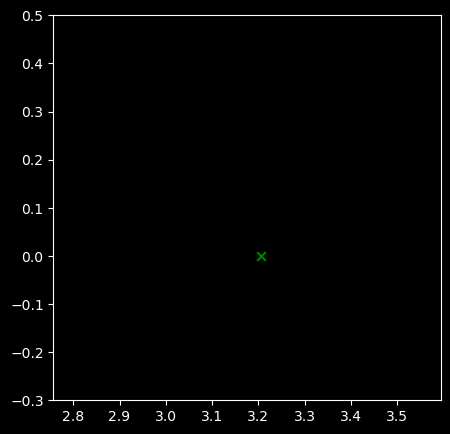

Timepoint: 3
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102618_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


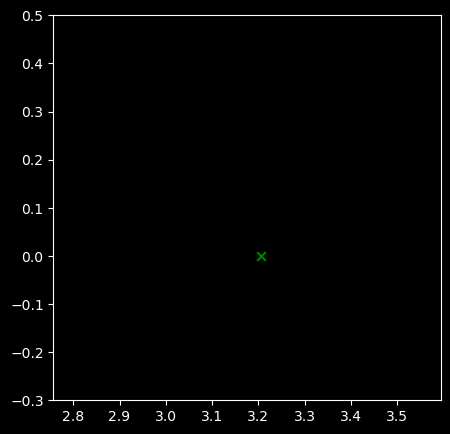

Timepoint: 4
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102649_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


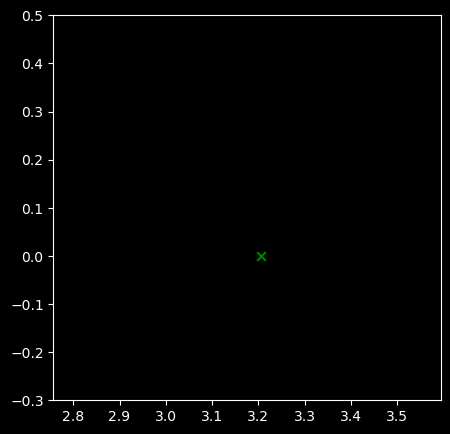

Timepoint: 5
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102721_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


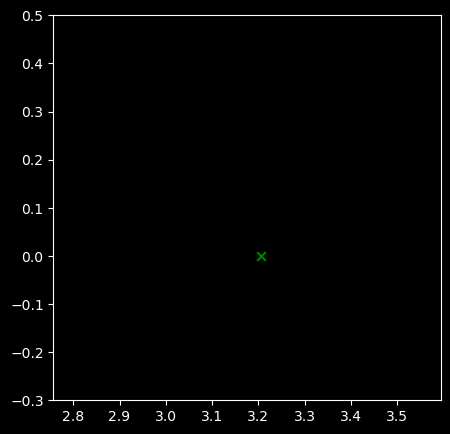

Timepoint: 6
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102753_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


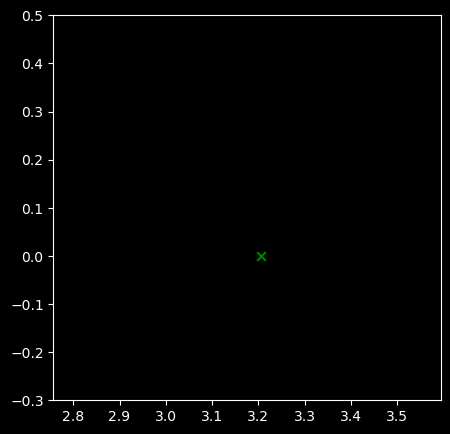

Timepoint: 7
c:\Users\alvelidjonatan\Documents\GitHub\etMINFLUX-analysis-public\exampledata\dyn1\241101\sample1\cell2\e1\241101-102824_ROI0-Pos[189,43]-Size[0.50,0.50]-RecTime[24.npy


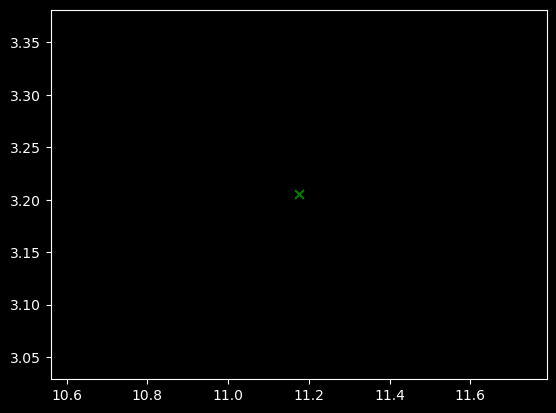

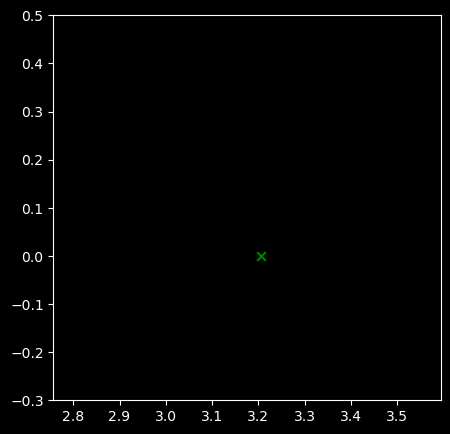

In [14]:
### Filter and plot all tracks in 2D, in yz-section across site position
#%matplotlib agg
#%matplotlib agg
%matplotlib inline

for roi_text in roi_texts:
    filelist = os.listdir(folder)
    filelist_npy = [file for file in filelist if file.endswith('.npy')]
    filelist_npy = [file for file in filelist_npy if roi_text+'-' in file]
    filelist_rawtif = [file for file in filelist if file.endswith('.tif') and 'raw' in file]
    filelist_msr = [file for file in filelist if file.endswith('.msr')]

    file_idx_msr_conf = 0

    # load msr file to read confocal image settings
    # get metadata from confocal image in msr file (pixel size, image shape, image size, origin offset)
    file_msr = os.path.join(folder, filelist_msr[file_idx_msr_conf])
    msr_dataset = obf_support.File(file_msr)
    conf_msr_stack_index = 0
    conf_stack = msr_dataset.stacks[conf_msr_stack_index]
    pxsize = conf_stack.pixel_sizes[0]*1e6
    pxshift = pxsize/2
    conf_size_px = (conf_stack.shape[0], conf_stack.shape[1])
    conf_size = (conf_stack.lengths[0]*1e6, conf_stack.lengths[1]*1e6)
    conf_offset = (conf_stack.offsets[0]*1e6, conf_stack.offsets[1]*1e6)

    # load confocal image and imshow it
    file_rawtif = os.path.join(folder, filelist_rawtif[file_idx_msr_conf])
    conf_stack = tiff.imread(file_rawtif)
    conf_img = conf_stack[-1]

    fig1 = plt.figure(figsize=(5,5))
    ax1 = fig1.add_subplot(111)

    conf_imgax = ax1.imshow(conf_img, cmap='gray', alpha=1)
    extents_confimg = np.array(conf_imgax.get_extent())*pxsize+[pxsize/2, pxsize/2, pxsize/2, pxsize/2]+[conf_offset[0], conf_offset[0], conf_offset[1], conf_offset[1]]
    conf_imgax.set_extent(extents_confimg)  # scale overlay image to the correct pixel size for the tracks

    file_idx_npy = 0
    for file_idx_npy in range(len(filelist_npy)):
        print(f'Timepoint: {file_idx_npy}')
        file_npy = os.path.join(folder, filelist_npy[file_idx_npy])
        dataset = np.load(file_npy)
        print(file_npy)

        # get all (x,y,z) coodinates and plot them in a 2D scatter
        loc_it = 4

        x = np.zeros((len(dataset),1))
        y = np.zeros((len(dataset),1))
        z = np.zeros((len(dataset),1))
        z1 = np.zeros((len(dataset),1))
        tid = np.zeros((len(dataset),1))
        tim = np.zeros((len(dataset),1))
        efo = np.zeros((len(dataset),1))
        for i in range(len(dataset)):
            x[i] = dataset[i][0][loc_it][2][0]
            y[i] = dataset[i][0][loc_it][2][1]
            z[i] = dataset[i][0][loc_it][2][2]
            z1[i] = dataset[i][0][1][2][2]
            efo[i] = dataset[i][0][loc_it][6]
            tid[i] = dataset[i][4]
            tim[i] = dataset[i][3]
        x = x * 1e6
        x = x.flatten()
        if file_idx_npy == 0:
            xlim = [np.min(x)-0.1, np.max(x)+0.1]
        y = y * 1e6
        y = y.flatten()
        if file_idx_npy == 0:
            ylim = [np.min(y)-0.1, np.max(y)+0.1]
        z = z * 1e6
        z = z.flatten()
        z1 = z1 * 1e6
        z1 = z1.flatten()
        tid = tid.flatten()
        tim = tim.flatten()
        efo = efo.flatten()
        track_ids = list(map(int, set(tid)))
        track_ids.sort()
        data_df = pd.DataFrame(columns=['tridx', 'tim0', 'x', 'y', 'z', 'tim', 'dt', 'efo', 'lims', 'z1', 'z1_diff', 'z_std', 'z_range'])
        for track in track_ids[::]:
            data_row = []
            x_track = np.array([val for val,tr in zip(x,tid) if tr==track]).flatten()
            y_track = np.array([val for val,tr in zip(y,tid) if tr==track]).flatten()
            z_track = np.array([val for val,tr in zip(z,tid) if tr==track]).flatten()
            z1_track = np.array([val for val,tr in zip(z1,tid) if tr==track]).flatten()
            tim_track = np.array([val for val,tr in zip(tim,tid) if tr==track]).flatten()
            efo_track = np.array([val for val,tr in zip(efo,tid) if tr==track]).flatten()
            z_diff = z_track - z1_track[0]
            data_row.append(track)
            data_row.append(tim_track[0])
            data_row.append(x_track)
            data_row.append(y_track)
            data_row.append(z_track)
            tim_track = tim_track - tim_track[0]
            data_row.append(tim_track)
            data_row.append(np.diff(tim_track))
            data_row.append(efo_track)
            data_row.append([np.min(x), np.max(x), np.min(y), np.max(y), np.min(z), np.max(z)])
            data_row.append(z1_track)
            data_row.append(z_diff)
            data_row.append(np.std(z_track))
            data_row.append(np.max(z_track)-np.min(z_track))
            data_df = pd.concat([data_df, pd.DataFrame([data_row], columns=data_df.columns)], ignore_index=True)

        zstds = []
        zspans = []
        max_efo = 0
        max_tim = 0
        max_dt = 0

        trs = np.arange(0,len(data_df))
        for tr in trs:
            dt_track_full = np.array(data_df.iloc[tr]['dt'])*1e6
            dt_track_full = np.insert(dt_track_full,0,0)
            if len(dt_track_full) > window_pts:
                local_dt_full = []
                for i in np.arange(0, len(dt_track_full)):
                    if i > int(window_pts/2) and i < len(dt_track_full)-int(window_pts/2)-1:
                        local_dt_full.append(np.mean(dt_track_full[i-int(window_pts/2):i+int(window_pts/2)]))
                    else:
                        local_dt_full.append(np.nan)
                local_dt_full = np.array(local_dt_full)
                idx_lists = consecutive_bool(np.argwhere(local_dt_full<dt_loc_thresh).flatten())
                # loop through all accepted tracks
                for idx_list in idx_lists:
                    dt_track = dt_track_full[idx_list]
                    if len(dt_track) > len_lim:
                        x_track = data_df.iloc[tr]['x'][idx_list]
                        y_track = data_df.iloc[tr]['y'][idx_list]
                        z_track = data_df.iloc[tr]['z'][idx_list]
                        tim_track = data_df.iloc[tr]['tim'][idx_list]
                        efo_track = data_df.iloc[tr]['efo'][idx_list]
                        local_dt = local_dt_full[idx_list]
                        z1_track = data_df.iloc[tr]['z1'][idx_list]
                        z1diff_track = data_df.iloc[tr]['z1_diff'][idx_list]
                        zstd = np.std(z_track)
                        zspan = np.max(z_track)-np.min(z_track)
                        zstds.append(zstd)
                        zspans.append(zspan)

                        if np.max(efo_track) > max_efo:
                            max_efo = np.max(efo_track)
                        if np.max(dt_track) > max_dt:
                            max_dt = np.max(dt_track)
                        if np.max(tim_track) > max_tim:
                            max_tim = np.max(tim_track)

                        local_efo = []
                        for i in np.arange(0, len(efo_track)):
                            if i > int(window_pts/2) and i < len(dt_track)-int(window_pts/2)-1:
                                local_efo.append(np.mean(efo_track[i-int(window_pts/2):i+int(window_pts/2)]))
                            else:
                                local_efo.append(np.nan)
                        sc = ax1.scatter(x_track, y_track, c=z_track, cmap='Reds', s=2, alpha=0.25, rasterized=True)

        if file_idx_npy == 0:
            # plot event coordinates
            roi_pos = (int(file_npy.split('[')[1].split(',')[0]),int(file_npy.split(']')[0].split(',')[1]))
            plt.colorbar(ScalarMappable(cmap=sc.get_cmap(), norm=sc.norm), label='z [um]')
            plt.xlim(*xlim)
            plt.ylim(*ylim)
            plt.gca().invert_yaxis()
        elif file_idx_npy == len(filelist_npy)-1:
            plt.scatter(roi_pos[0]*pxsize+pxsize/2+conf_offset[0], roi_pos[1]*pxsize+pxsize/2+conf_offset[1], marker='x', color='green', s=40)

        xpos = roi_pos[0]*pxsize+pxsize/2+conf_offset[0]
        fig2 = plt.figure(figsize=(5,5))
        ax2 = fig2.add_subplot(111)
        trs = np.arange(0,len(data_df))
        for tr in trs:
            dt_track_full = np.array(data_df.iloc[tr]['dt'])*1e6
            dt_track_full = np.insert(dt_track_full,0,0)
            if len(dt_track_full) > window_pts:
                local_dt_full = []
                for i in np.arange(0, len(dt_track_full)):
                    if i > int(window_pts/2) and i < len(dt_track_full)-int(window_pts/2)-1:
                        local_dt_full.append(np.mean(dt_track_full[i-int(window_pts/2):i+int(window_pts/2)]))
                    else:
                        local_dt_full.append(np.nan)
                local_dt_full = np.array(local_dt_full)
                idx_lists = consecutive_bool(np.argwhere(local_dt_full<dt_loc_thresh).flatten())
                # loop through all accepted tracks
                for idx_list in idx_lists:
                    dt_track = dt_track_full[idx_list]
                    if len(dt_track) > len_lim:
                        x_track = data_df.iloc[tr]['x'][idx_list]
                        y_track = data_df.iloc[tr]['y'][idx_list]
                        z_track = data_df.iloc[tr]['z'][idx_list]
                        x_mask = np.logical_and(x_track > xpos-xdepth, x_track < xpos+xdepth)
                        sc2 = ax2.scatter(y_track[x_mask], z_track[x_mask], color='k', s=5, alpha=0.25, rasterized=True)

        roi_pos = (int(file_npy.split('[')[1].split(',')[0]),int(file_npy.split(']')[0].split(',')[1]))
        plt.scatter(roi_pos[1]*pxsize+pxsize/2+conf_offset[1], 0, marker='x', color='green', s=40)
        plt.xlim(*ylim)
        plt.ylim([-0.3,0.5])
        plt.show()

    #pdf = matplotlib.backends.backend_pdf.PdfPages(os.path.join(folder,f"plot-3Dxslicing-{roi_text}.pdf"))
    #for i in plt.get_fignums():
    #    pdf.savefig(i)
    #pdf.close()
    #plt.close('all')